In [1]:
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
sys.path.append('./../src/')
import dill
# thresh=10
# dill.load_session(f'base.db')
import obonet
import networkx as nx
import copy
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

In [2]:
date="sep2024"

In [3]:
atleast=2

In [4]:
uberon=obonet.read_obo('./../annotation/uberon_ext.obo')
#dictionary of names to id 
id_to_name = {id_:data.get('name') for id_, data in uberon.nodes(data=True)}
name_to_id = {data.get('name'):id_ for id_, data in uberon.nodes(data=True)}

In [5]:
import utils

In [6]:
def node_with_attribute(g, k, v=None):
    if v:
        return [n for n, d in g.nodes(data=True) if k in d and v in d[k]]
    else:
        return [n for n, d in g.nodes(data=True) if k in d]

In [7]:
def get_positives(graph, node, meta):
    #get UBERON ID of positives (node + descendants of node) with samples
    positive_labels_from_graph=[id_to_name[x] for x in nx.ancestors(graph, node)]+[id_to_name[node]]
    positive_labels_with_sample=list(set(positive_labels_from_graph).intersection(set(meta)))
    return [name_to_id[x] for x in positive_labels_with_sample]

def get_neutrals(graph, node, meta):
    #get UBERON ID of neutrals (ancestors of node) with samples
    neutral_labels_from_graph=[id_to_name[x] for x in nx.ancestors(graph, node)]+[id_to_name[node]]
    neutral_labels_with_sample=list(set(neutral_labels_from_graph).intersection(set(meta)))
    return [name_to_id[x] for x in neutral_labels_with_sample]

In [8]:
def reroute(tree, from_node, to_node):
    tree_copy=copy.deepcopy(tree)
    # print(f'from: {from_node}')
    # print(f'to: {to_node}')
    # print("in:")
    for e in tree.in_edges(from_node):
        if e[0]!=to_node: tree_copy.add_edge(e[0], to_node, list(tree.get_edge_data(e[0],e[1]).keys())[0])
        tree_copy.remove_edge(e[0],e[1])
        # print(e)
        # print(e[0], to_node)
    # print("out:")
    for e in tree.out_edges(from_node):
        if e[1]!=to_node: tree_copy.add_edge(to_node, e[1], list(tree.get_edge_data(e[0],e[1]).keys())[0])
        tree_copy.remove_edge(e[0],e[1])
        # print(e)
        # print(to_node, e[1])
    print(f'{from_node} is isolate: {nx.is_isolate(tree_copy, from_node)}')
    tree_copy.remove_node(from_node)
    return tree_copy

def filter_edge(n1, n2, edgekey):
    return edgekey in ['is_a', 'part_of']

def collapse(tree, root, tissues):
    tree_copy=copy.deepcopy(tree)
    tree_copy=nx.MultiDiGraph(tree_copy)
    
    pos=graphviz_layout(tree, prog='dot', root=name_to_id[root])
    pos={k:v for k, v in sorted(pos.items(), key=lambda item: item[1][1])}

    for node in pos.keys():
        if name_to_id['anatomical system'] in tree.successors(node) and id_to_name[node].split()[-1]=='system': continue
        if id_to_name[node] not in tissues:
            parents=list(tree_copy.successors(node))
            children=list(tree_copy.predecessors(node))
            if len(parents)==1 and len(children)==1:
                tree_copy.add_edge(children[0], parents[0], list(tree_copy.get_edge_data(node, parents[0]).keys())[0])
                tree_copy.remove_node(node)
    return tree_copy

def cut_collapse(tree, meta_tissues, wanted, unwanted, display=True):
    cut_tree=tree.subgraph([x for x in tree.nodes() if x not in unwanted])
    cut_tree=nx.MultiDiGraph(collapse(cut_tree, root, [id_to_name[x] for x in wanted]))

    keep_comp=list()
    for comp in nx.weakly_connected_components(cut_tree):
        if len(comp.intersection(set(wanted)))==1: keep_comp.extend(list(comp.intersection(set(wanted))))
        elif any(n in wanted for n in list(comp)): keep_comp.extend(list(comp))
    cut_tree=nx.MultiDiGraph(cut_tree.subgraph([x for x in cut_tree.nodes() if x in keep_comp]))
    
    cut_pos=graphviz_layout(cut_tree, prog='dot', root=name_to_id[root])
    for key in cut_pos.keys():
        x,y=cut_pos[key]
        cut_pos[key]=(x,-y)
    cut_label=dict((k, label_dict[k]) for k in list(cut_tree.nodes()) if k in label_dict)

    meta_node=[name_to_id[x] for x in meta_tissues if name_to_id[x] in cut_pos.keys()]
    noninformative=[n for n in cut_tree.nodes() 
                    if 'subset' in cut_tree.nodes[n] and ('non_informative' in cut_tree.nodes[n]['subset']
                    or 'upper_level' in cut_tree.nodes[n]['subset'])]
    rest_node=[x for x in set(cut_tree.nodes)-set(meta_node)-set(noninformative)]

    if display:
        plt.figure(dpi=300)
        node_size=200
        font_size=3
        nx.draw(cut_tree, cut_pos, nodelist=meta_node, node_color='#00bfff', labels=cut_label, with_labels=True, arrows=False,
                font_size=font_size, node_size=node_size) # BLUE
        nx.draw(cut_tree, cut_pos, nodelist=noninformative, node_color='#90EE90', labels=cut_label, with_labels=True, arrows=False, 
                font_size=font_size, node_size=node_size) # GREEN
        nx.draw(cut_tree, cut_pos, nodelist=rest_node, node_color='#abc2c1', labels=cut_label, with_labels=True, arrows=False, 
                font_size=font_size, node_size=node_size) # GREY
        nx.draw_networkx_edges(
            cut_tree,
            cut_pos,
            edgelist=[e for e in cut_tree.edges() if 'is_a' in cut_tree.get_edge_data(e[0], e[1])],
            width=1,
            alpha=1,
            edge_color="tab:red",
        arrows=False)
        nx.draw_networkx_edges(
            cut_tree,
            cut_pos,
            edgelist=[e for e in cut_tree.edges() if 'part_of' in cut_tree.get_edge_data(e[0], e[1])],
            width=1,
            alpha=1,
            edge_color="tab:blue",
        arrows=False)
        
    return cut_tree

def remove_triangle(tree, display=True):
    copy_tree=copy.deepcopy(tree)
    
    adj=pd.DataFrame(nx.to_numpy_array(copy_tree), index= copy_tree.nodes(), columns=copy_tree.nodes())
    adj2=pd.DataFrame(np.matmul(adj, adj), index= copy_tree.nodes(), columns=copy_tree.nodes())

    for n in tree.nodes:
        children=adj[adj.loc[n]>0].index
        grandchildren=adj2[adj2.loc[n]>0].index
        triangle=children & grandchildren
        if len(triangle)>0:
            for x in triangle:
                copy_tree.remove_edge(n, x)
                print(f"removed edge between {id_to_name[n]} and {id_to_name[x]}")

    if display:
        cut_pos=graphviz_layout(copy_tree, prog='dot', root=name_to_id[root])
        for key in cut_pos.keys():
            x,y=cut_pos[key]
            cut_pos[key]=(x,-y)
        cut_label=dict((k, label_dict[k]) for k in list(copy_tree.nodes()) if k in label_dict)

        meta_node=[name_to_id[x] for x in mult_meta['tissue_name'] if name_to_id[x] in cut_pos.keys()]
        noninformative=[n for n in copy_tree.nodes() 
                        if 'subset' in copy_tree.nodes[n] and ('non_informative' in copy_tree.nodes[n]['subset']
                        or 'upper_level' in copy_tree.nodes[n]['subset'])]
        rest_node=[x for x in set(cut_tree.nodes)-set(meta_node)-set(noninformative)]
        
        #display final structure
        plt.figure(dpi=300)
        node_size=200
        font_size=3
        nx.draw(copy_tree, cut_pos, nodelist=meta_node, node_color='#00bfff', labels=cut_label, with_labels=True, arrows=False,
                font_size=font_size, node_size=node_size) # BLUE
        nx.draw(copy_tree, cut_pos, nodelist=noninformative, node_color='#90EE90', labels=cut_label, with_labels=True, arrows=False, 
                font_size=font_size, node_size=node_size) # GREEN
        # nx.draw(cut_tree, cut_pos, nodelist=basic_node, node_color='#ffffe0', labels=cut_label, with_labels=True, arrows=False, 
        #         font_size=font_size, node_size=node_size) # YELLOW
        nx.draw(copy_tree, cut_pos, nodelist=rest_node, node_color='#abc2c1', labels=cut_label, with_labels=True, arrows=False, 
                font_size=font_size, node_size=node_size) # GREY
        nx.draw_networkx_edges(
            copy_tree,
            cut_pos,
            edgelist=[e for e in copy_tree.edges() if 'is_a' in copy_tree.get_edge_data(e[0], e[1])],
            width=1,
            alpha=1,
            edge_color="tab:red",
        arrows=False)
        nx.draw_networkx_edges(
            copy_tree,
            cut_pos,
            edgelist=[e for e in copy_tree.edges() if 'part_of' in copy_tree.get_edge_data(e[0], e[1])],
            width=1,
            alpha=1,
            edge_color="tab:blue",
        arrows=False)
    return copy_tree

def collapse_same_children_same_parents(tree):
    nodelist=list(tree.nodes)
    samedict=dict()
    for i,node in enumerate(nodelist):
        wanted_children=set(list(nx.ancestors(tree,node)))
        wanted_parents=set(list(tree.successors(node)))
        samelist=list()
        if len(wanted_children)==0:
            continue
        for j in range(i+1, len(nodelist)):
            test_children=set(list(nx.ancestors(tree,nodelist[j])))
            test_parents=set(list(tree.successors(nodelist[j])))
            if wanted_children==test_children and wanted_parents==test_parents: 
                if nodelist[j] not in samelist: samelist+=[nodelist[j]]
        if len(samelist)>0: samedict[node]=samelist
    [tree.remove_nodes_from(v) for k,v in samedict.items()]
    return tree

def collapse_same_pos_same_neut(graph, meta):
    nodelist = list(graph.nodes)
    samedict = dict()
    for i,node in enumerate(nodelist):
        wanted_pos = get_positives(graph, node, meta)
        wanted_neut = get_neutrals(graph, node, meta)
        samelist=list()
        if len(wanted_neut)==0 and len(wanted_pos)==0:
            continue
        for j in range(i+1, len(nodelist)):
            test_node=nodelist[j]
            test_pos = get_positives(graph, test_node, meta)
            test_neut = get_neutrals(graph, test_node, meta)
            if wanted_pos==test_pos and wanted_neut==test_neut: 
                if test_node not in samelist: samelist+=[test_node]
        if len(samelist)>0 and id_to_name[node] not in meta: samedict[node]=samelist
    return samedict

def check_graph(g):
    if isinstance(g, nx.MultiDiGraph):
        print(f"directed acyclic graph: {nx.is_directed_acyclic_graph(g)}")
        print(f"weakly connected: {nx.is_weakly_connected(g)}")
        print(f"strongly connected: {nx.is_strongly_connected(g)}")
        print(f"weakly connected components: {[len(c) for c in nx.weakly_connected_components(g)]}")
    else:
        print(f"connected: {nx.is_connected(g)}")
        print(f"components: {[len(c) for c in nx.connected_components(g)]}")

In [9]:
check_graph(uberon)

directed acyclic graph: False
weakly connected: False
strongly connected: False
weakly connected components: [19557, 1, 6, 1]


In [10]:
#filter by edge type
filtered_uberon = nx.subgraph_view(uberon, filter_edge=filter_edge)
filtered_uberon=nx.MultiDiGraph(filtered_uberon)
filtered_uberon.remove_nodes_from(list(nx.isolates(filtered_uberon)))

In [11]:
check_graph(filtered_uberon)

directed acyclic graph: True
weakly connected: False
strongly connected: False
weakly connected components: [19425, 11, 6, 21]


In [12]:
### reroute anatomical entity

print([x for x in id_to_name.keys() if id_to_name[x]=='anatomical entity'])

filtered_uberon=reroute(filtered_uberon, 'CARO:0000000', 'UBERON:0001062')
id_to_name.pop('CARO:0000000')

['CARO:0000000', 'UBERON:0001062']
CARO:0000000 is isolate: True


'anatomical entity'

In [13]:
### reroute pancreas

filtered_uberon=reroute(filtered_uberon, name_to_id['exocrine pancreas'], name_to_id['pancreas'])
filtered_uberon=reroute(filtered_uberon, name_to_id['endocrine pancreas'], name_to_id['pancreas'])

UBERON:0000017 is isolate: True
UBERON:0000016 is isolate: True


In [14]:
### filter edge type

for e in filtered_uberon.edges():
    if 'is_a' not in filtered_uberon.get_edge_data(e[0],e[1]): 
        if 'part_of' not in filtered_uberon.get_edge_data(e[0],e[1]):
            print(e)
            print(filtered_uberon.get_edge_data(e[0],e[1]))

In [15]:
check_graph(filtered_uberon)

directed acyclic graph: True
weakly connected: False
strongly connected: False
weakly connected components: [19422, 11, 6, 21]


In [16]:
normal_Mv, normal_meta, filtered_island = dill.load(open(f'./../data/GEO/preprocessed/450K_Mvalues_atleast{atleast}_samplewise', 'rb'))
mult_meta=normal_meta

In [17]:
# slim_nodes=[x for x in filtered_uberon.nodes() 
#             if filtered_uberon.nodes[x].get('subset') and 'uberon_slim' in filtered_uberon.nodes[x].get('subset')]
# xref_nodes=[x for x in filtered_uberon.nodes() 
#             if filtered_uberon.nodes[x].get('xref') and 
#             any([('BTO' in x or 'HP' in x) for x in filtered_uberon.nodes[x].get('xref')])]

In [18]:
root='anatomical entity'
subtree=utils.create_subtree_root(filtered_uberon, list(mult_meta['tissue_name'].values), root)
subtree=nx.MultiDiGraph(subtree)
subtree_meta=mult_meta[mult_meta['tissue_name'].isin([id_to_name[x] for x in subtree.nodes()])]

In [19]:
check_graph(subtree)

directed acyclic graph: True
weakly connected: False
strongly connected: False
weakly connected components: [139, 1]


[139, 1]
['embryonic stem cell']


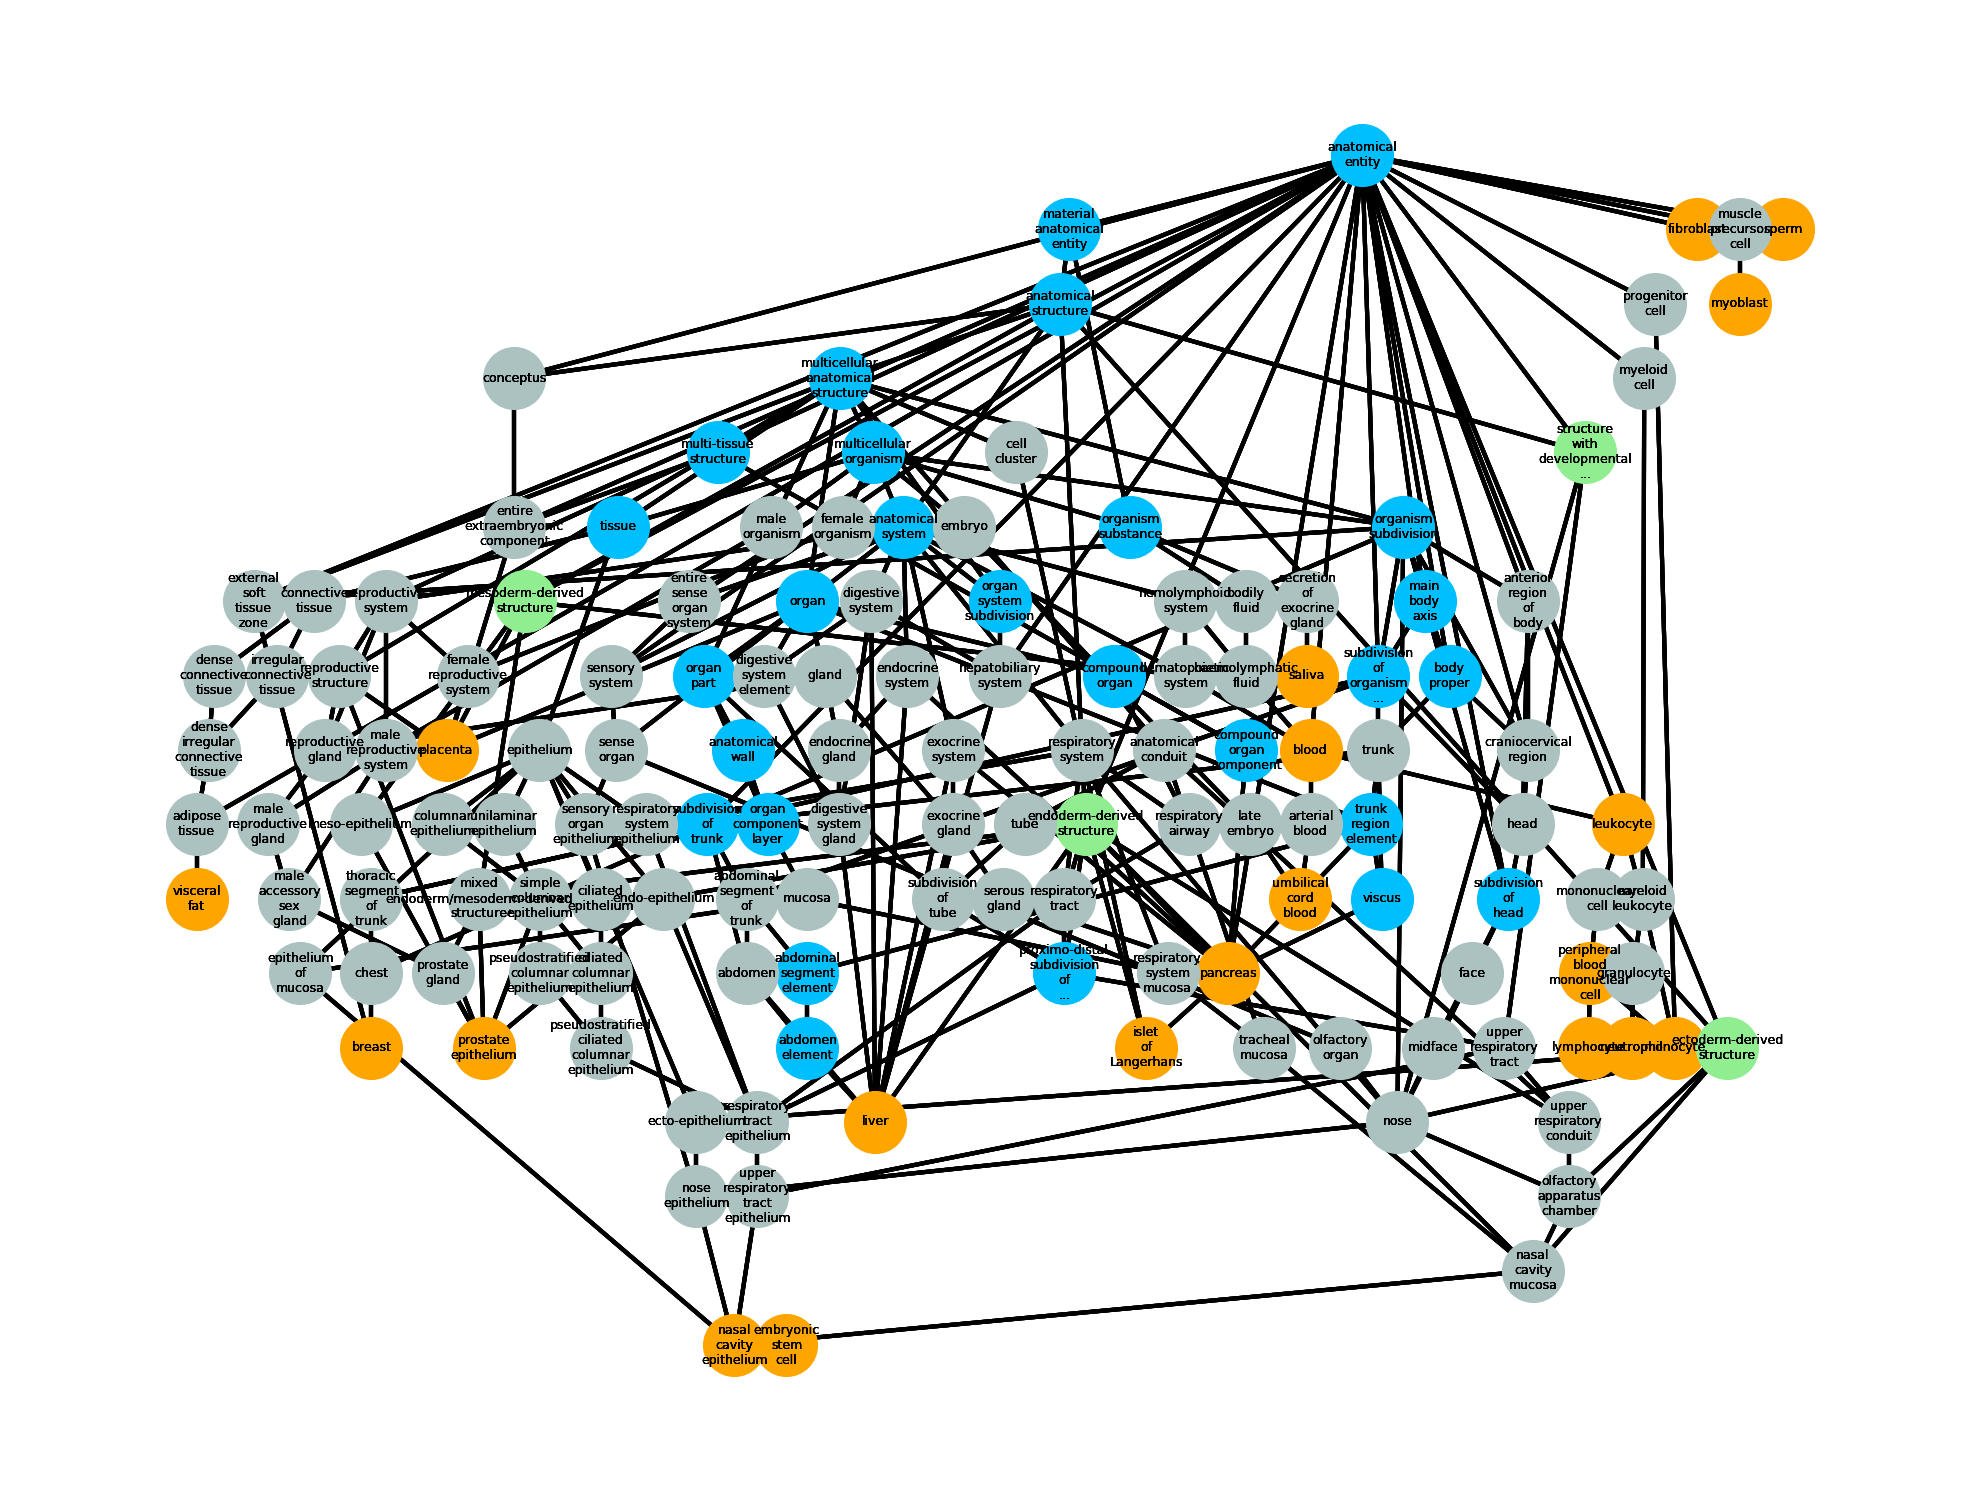

In [20]:
root='anatomical entity'
#subtree based on root
subtree=utils.create_subtree_root(filtered_uberon, list(mult_meta['tissue_name'].values), root)
subtree=nx.MultiDiGraph(subtree)
subtree_meta=mult_meta[mult_meta['tissue_name'].isin([id_to_name[x] for x in subtree.nodes()])]

### reconfigure blood subtree
subtree.remove_edge(name_to_id['monocyte'], name_to_id['mononuclear cell'])
subtree.remove_edge(name_to_id['lymphocyte'], name_to_id['mononuclear cell'])
subtree.add_edge(name_to_id['leukocyte'], name_to_id['blood'], 'is_a')
subtree.add_edge(name_to_id['monocyte'], name_to_id['peripheral blood mononuclear cell'], 'is_a')
subtree.add_edge(name_to_id['lymphocyte'], name_to_id['peripheral blood mononuclear cell'], 'is_a')

tissues=mult_meta['tissue_name'].unique()
pos=graphviz_layout(subtree, prog='dot', root=name_to_id[root])
x_pos=[pos[name_to_id[x]][0] for x in tissues if name_to_id[x] in pos.keys()]
ordered=[tissues[x] for x in np.argsort(x_pos)]

for key in pos.keys():
    x,y=pos[key]
    pos[key]=(x,-y)
label_dict={key:id_to_name[key] for key in subtree.nodes()}
for key in label_dict.keys():
    if len(label_dict[key].split(" "))>4:
        label_dict[key]=" ".join(label_dict[key].split()[:3])+"\n..."
    label_dict[key]=label_dict[key].replace(" ", "\n")

meta_node=[name_to_id[x] for x in mult_meta['tissue_name'].unique() if name_to_id[x] in pos.keys()]
noninformative=[n for n in subtree.nodes() 
                if 'subset' in subtree.nodes[n] and ('non_informative' in subtree.nodes[n]['subset']
                or 'upper_level' in subtree.nodes[n]['subset']
                                                    )]
field = "property_value"
value = "curator_notes \"Grouping term for query purposes\" xsd:string"
query_node = node_with_attribute(subtree, field, value)
rest_node=[x for x in set(subtree.nodes)-set(meta_node)-set(noninformative)-set(query_node)]

plt.figure(dpi=300)
node_size=200
font_size=3

blue = '#00bfff'
orange = '#FFA500'
green = '#90EE90'
grey = '#abc2c1'

nx.draw(subtree, pos, nodelist=meta_node, node_color=orange, labels=label_dict, with_labels=True, arrows=False, 
            font_size=font_size, node_size=node_size) # meta = ORANGE
nx.draw(subtree, pos, nodelist=noninformative, node_color=blue, labels=label_dict, with_labels=True, arrows=False, 
            font_size=font_size, node_size=node_size) # noninformative/upper level = BLUE
nx.draw(subtree, pos, nodelist=query_node, node_color=green, labels=label_dict, with_labels=True, arrows=False, 
            font_size=font_size, node_size=node_size) # query = GREEN
nx.draw(subtree, pos, nodelist=rest_node, node_color=grey, labels=label_dict, with_labels=True, arrows=False, 
            font_size=font_size, node_size=node_size) # rest = GREY

print([len(c) for c in nx.weakly_connected_components(subtree)])
[print([id_to_name[s] for s in c]) for c in nx.weakly_connected_components(subtree) if len(c)<5]
None

In [21]:
manual_exclude=['independent continuant','material entity','entity','anatomical collection', 'gland', 'anatomical conduit',
               'developing anatomical structure','midface','upper respiratory conduit','olfactory apparatus chamber',
               'structure with developmental contribution from neural crest','digestive system element','external soft tissue zone','extraembryonic structure',
               'object','root','conceptus','anterior region of body','tube','entire sense organ system','entire extraembryonic component', 
               "mucosa","sense organ","nose","face"]

In [22]:
excluded_properties = list()
for node in manual_exclude:
    excluded_properties.extend([[(key, v) for v in value] if isinstance(value, list) else (key, value) for key, value in filtered_uberon.nodes[name_to_id[node]].items()])

excluded_properties = [item for sublist in excluded_properties for item in (sublist if isinstance(sublist, list) else [sublist])]

In [23]:
name_to_id['entity']

'BFO:0000001'

In [24]:
counter = Counter(excluded_properties)
# counter.most_common()

directed acyclic graph: True
weakly connected: False
strongly connected: False
weakly connected components: [27, 10, 14, 1, 1, 1, 1, 1, 1, 1]


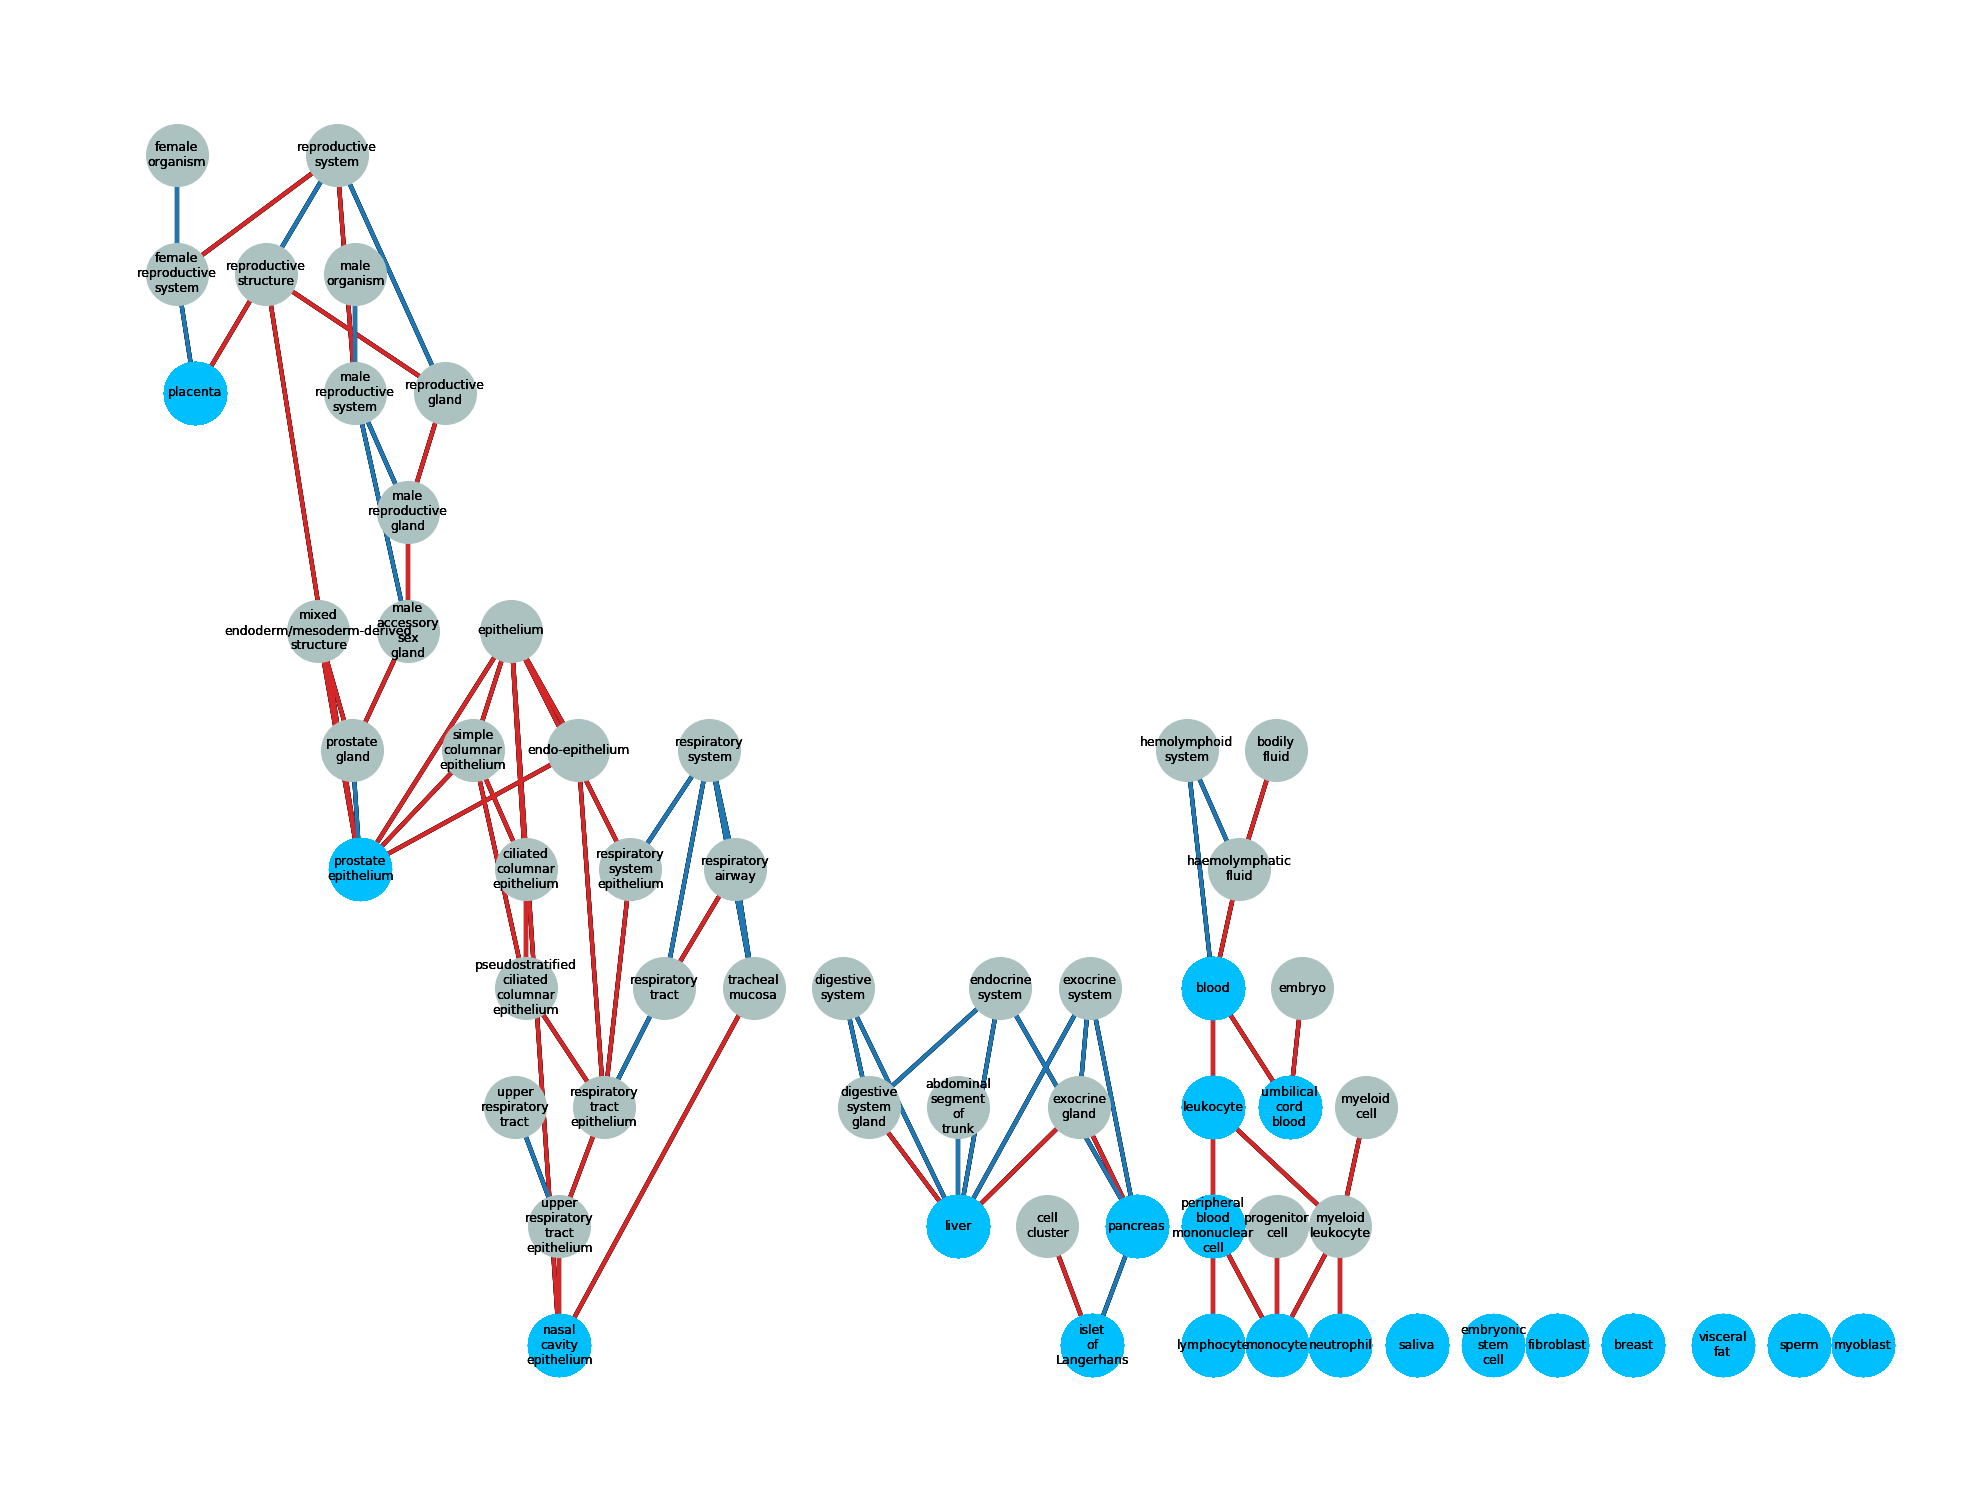

In [25]:
### cut non-informative, upper level
### cut query

wanted_tissue=list(mult_meta['tissue_name'].unique())
wanted_node=[name_to_id[x] for x in wanted_tissue]
unwanted_node=[x for x in subtree.nodes() if 'subset' in subtree.nodes[x].keys() 
               and ('non_informative' in subtree.nodes[x]['subset'] 
                    or 'upper_level' in subtree.nodes[x]['subset']
                   )]+[name_to_id[x] for x in manual_exclude]+query_node
# unwanted_node=[x for x in subtree.nodes() if 'subset' in subtree.nodes[x].keys() 
#                and ('non_informative' in subtree.nodes[x]['subset'] 
#                     or 'upper_level' in subtree.nodes[x]['subset']
#                    )]+query_node
cut_tree=cut_collapse(subtree, mult_meta['tissue_name'], wanted_node, unwanted_node)

check_graph(cut_tree)

cut collapse: 9 nodes
removed edge between liver and digestive system
removed edge between liver and exocrine system
removed edge between liver and endocrine system
removed edge between placenta and reproductive system
removed edge between pseudostratified ciliated columnar epithelium and simple columnar epithelium
removed edge between male accessory sex gland and male reproductive system
removed edge between ciliated columnar epithelium and epithelium
removed edge between reproductive gland and reproductive system
removed edge between respiratory tract and respiratory system
removed edge between pancreas and exocrine system
removed edge between prostate epithelium and epithelium
removed edge between prostate epithelium and mixed endoderm/mesoderm-derived structure
removed edge between tracheal mucosa and respiratory system
cut collapse: 4 nodes
removed edge between male reproductive gland and reproductive system
removed edge between nasal cavity epithelium and respiratory airway
remov

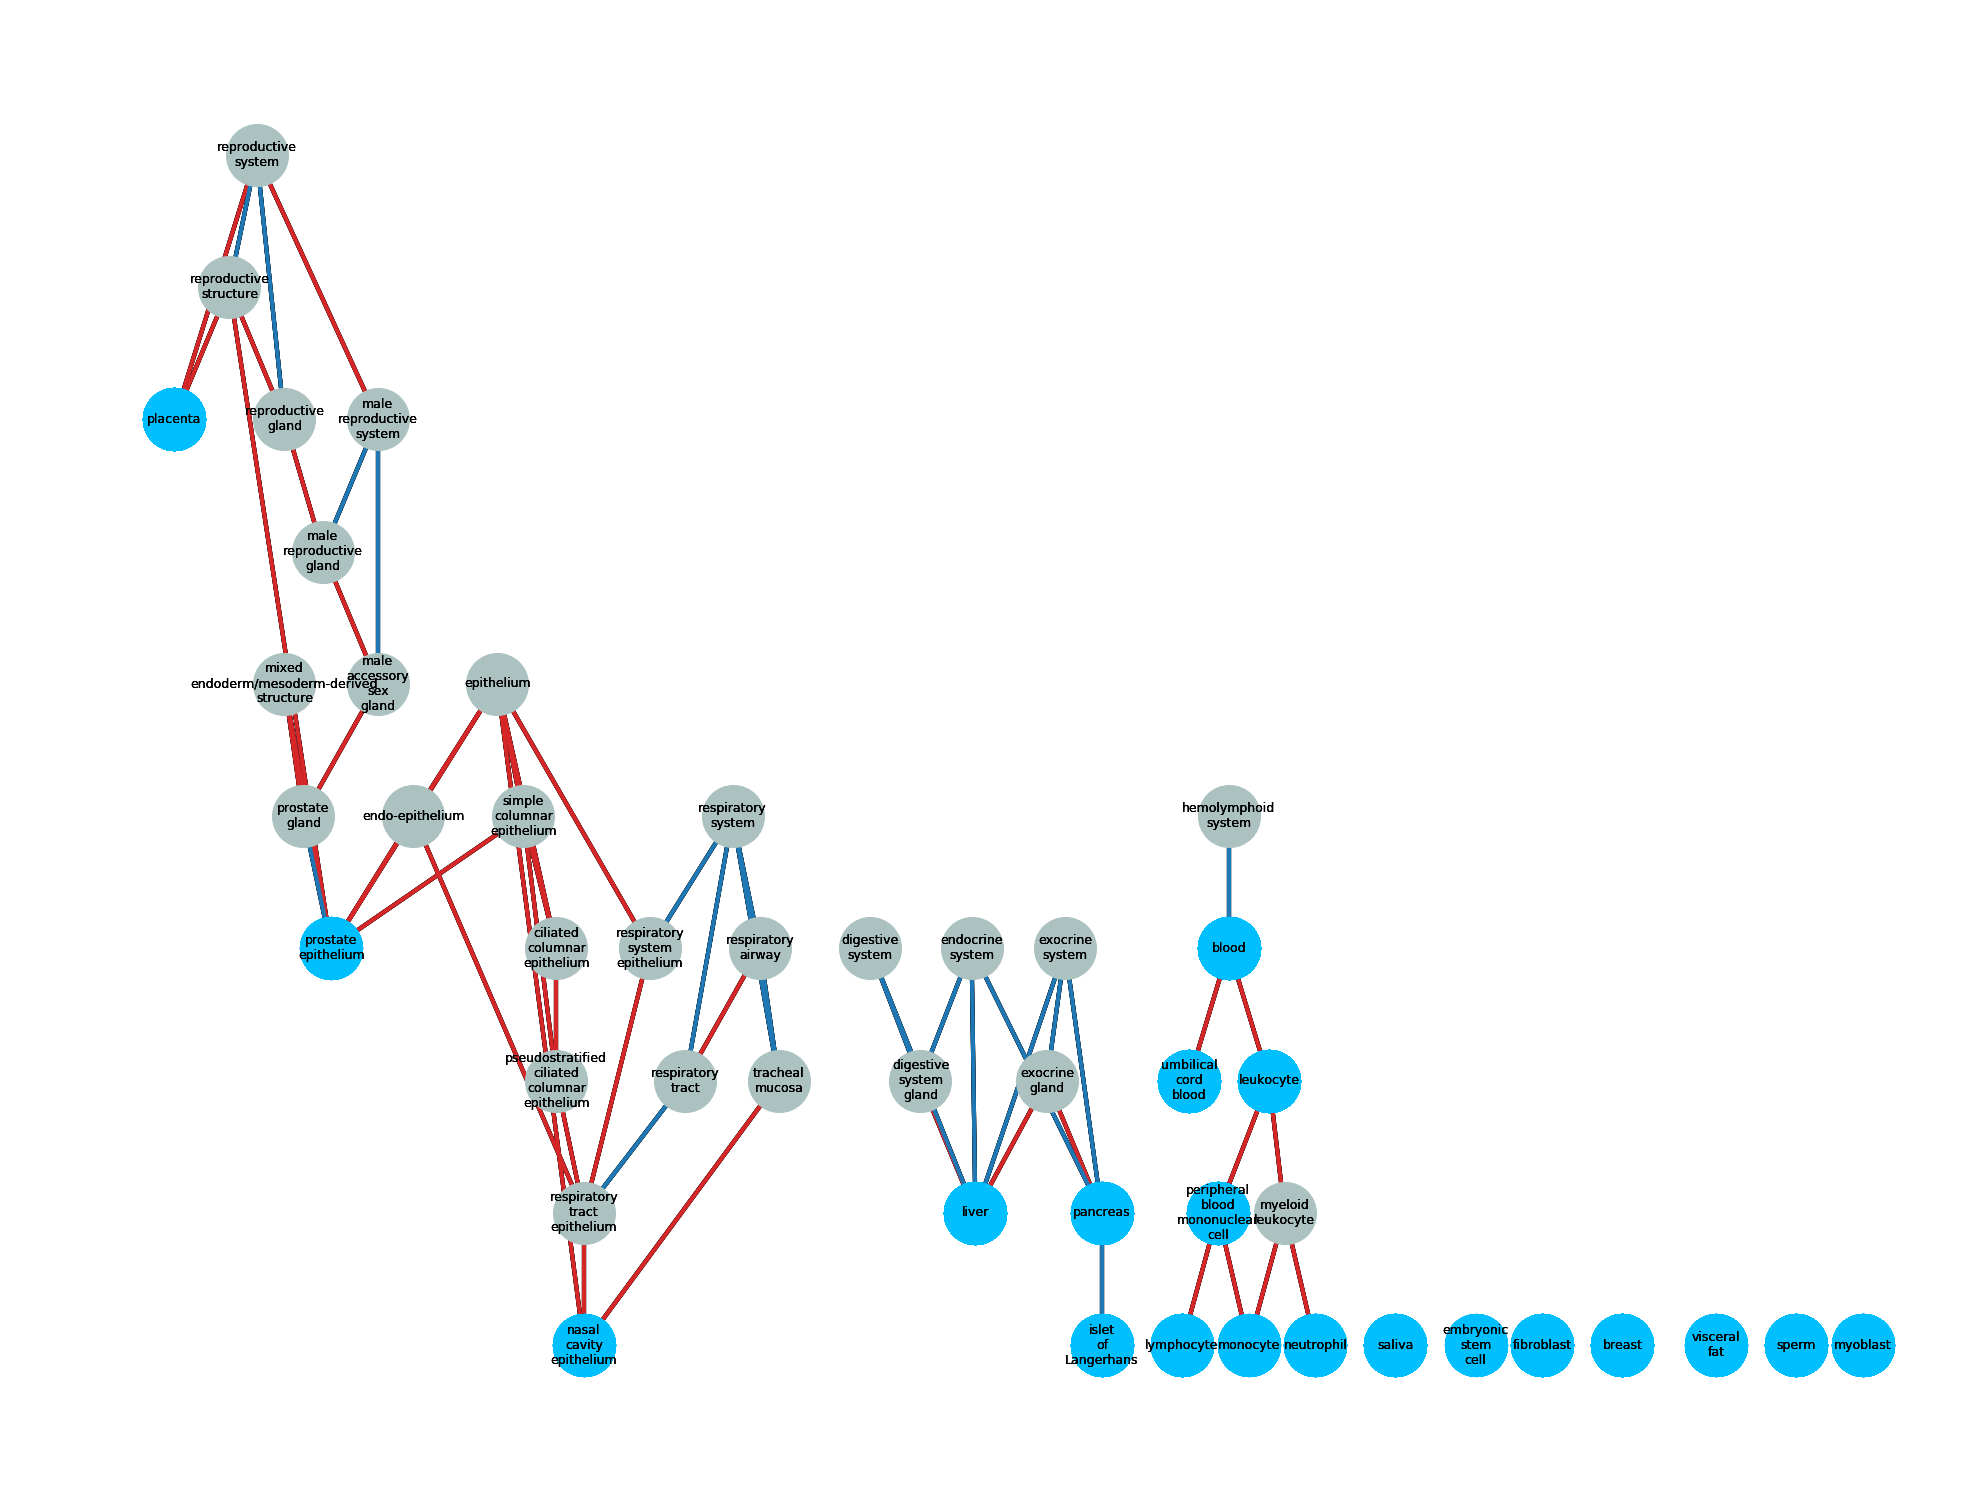

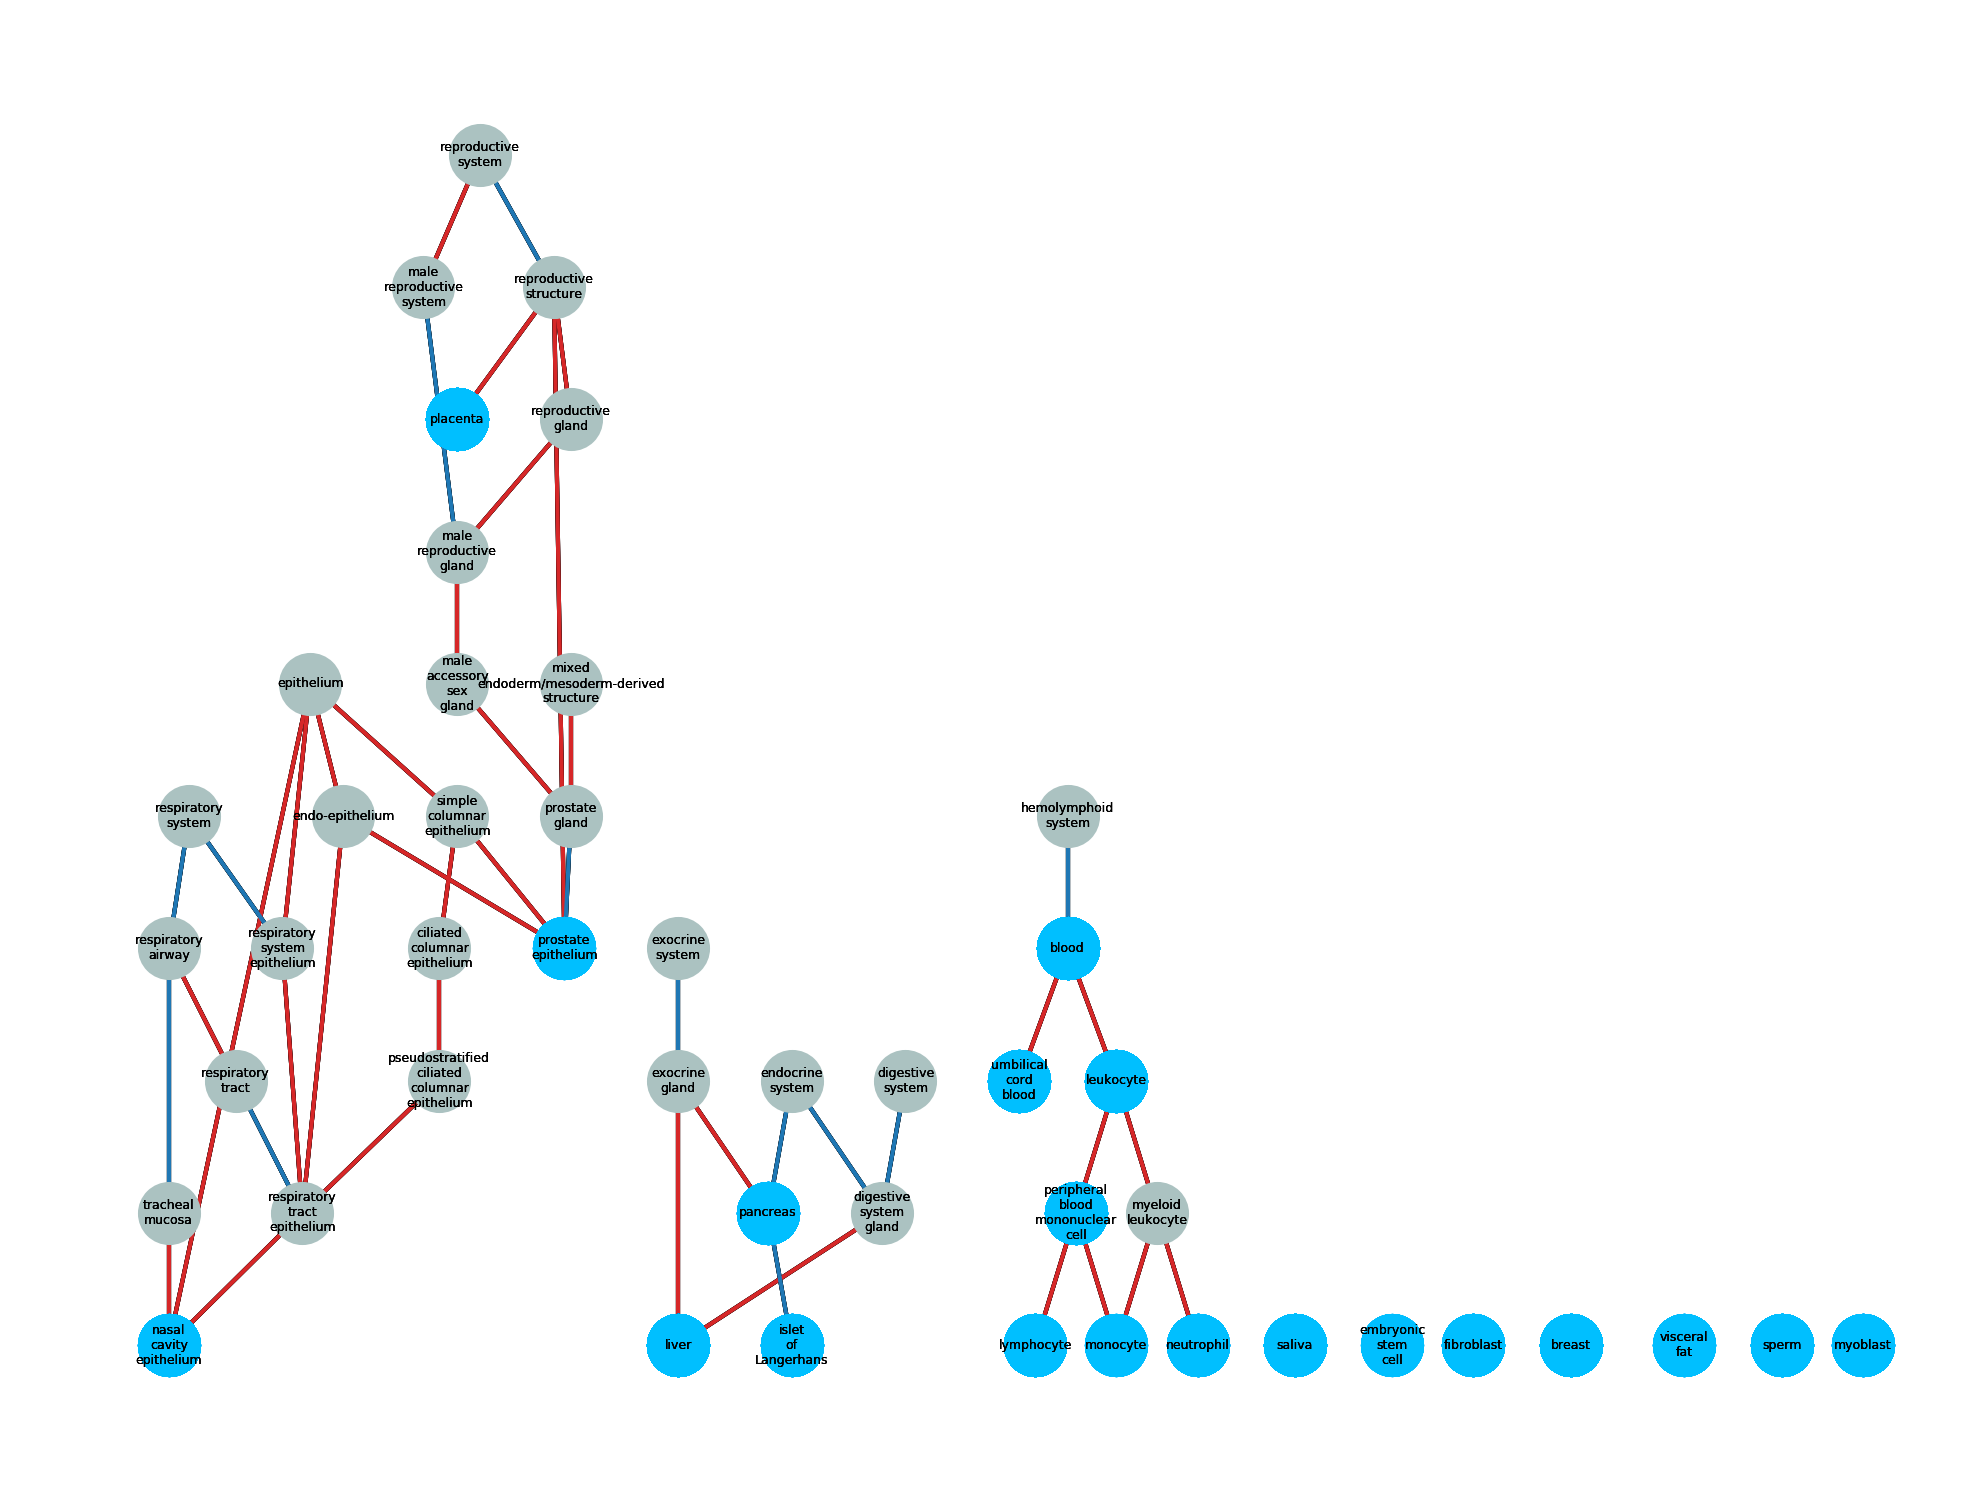

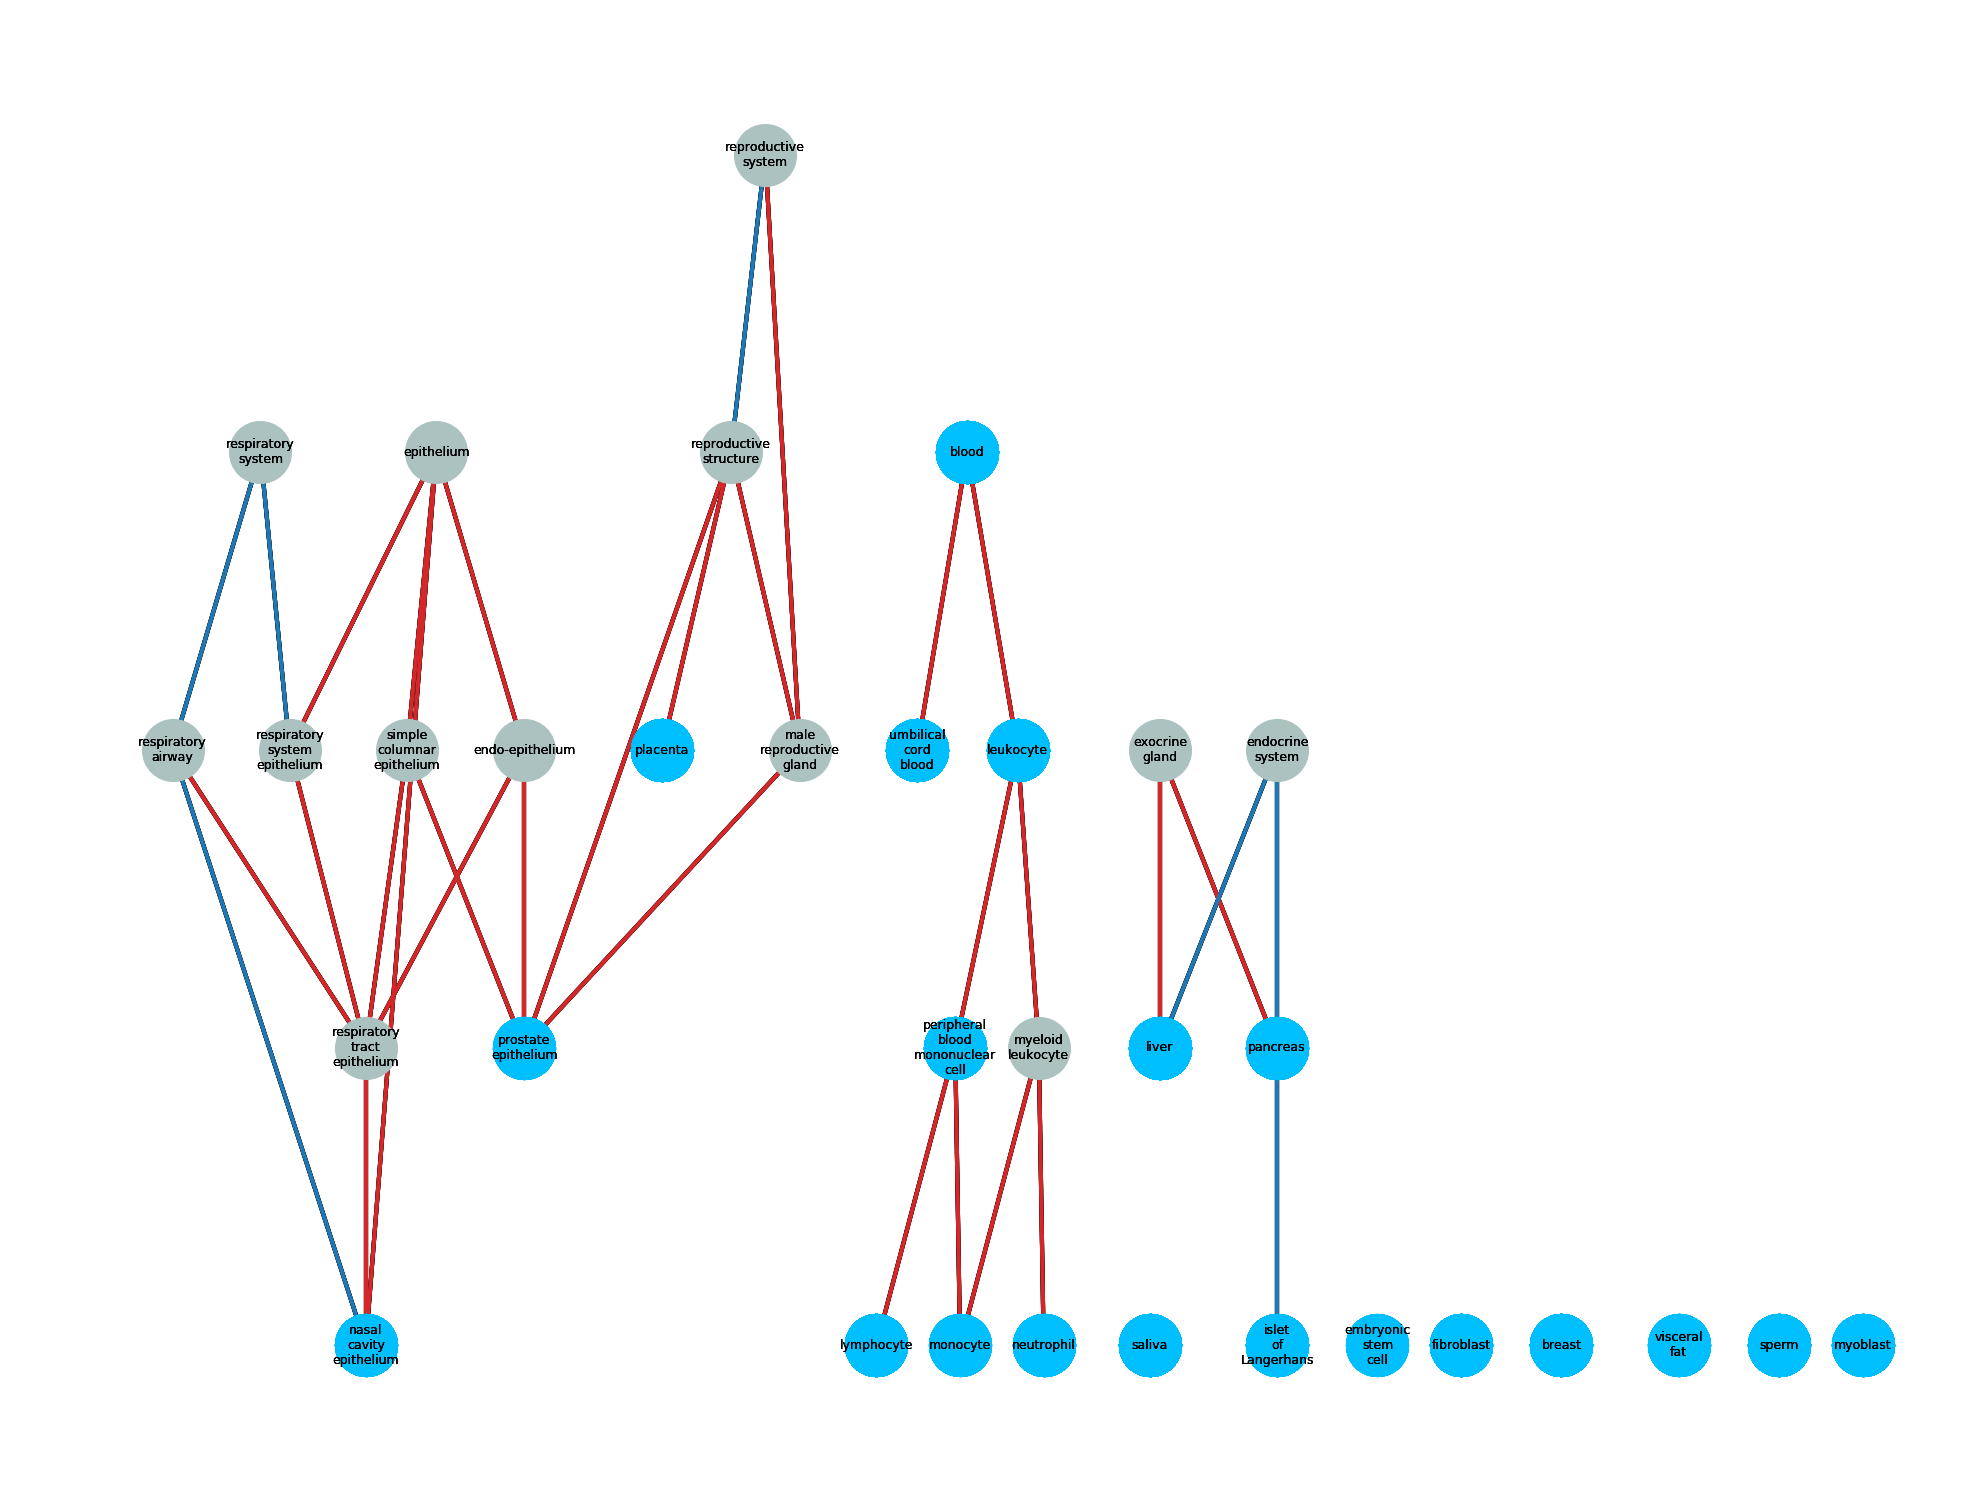

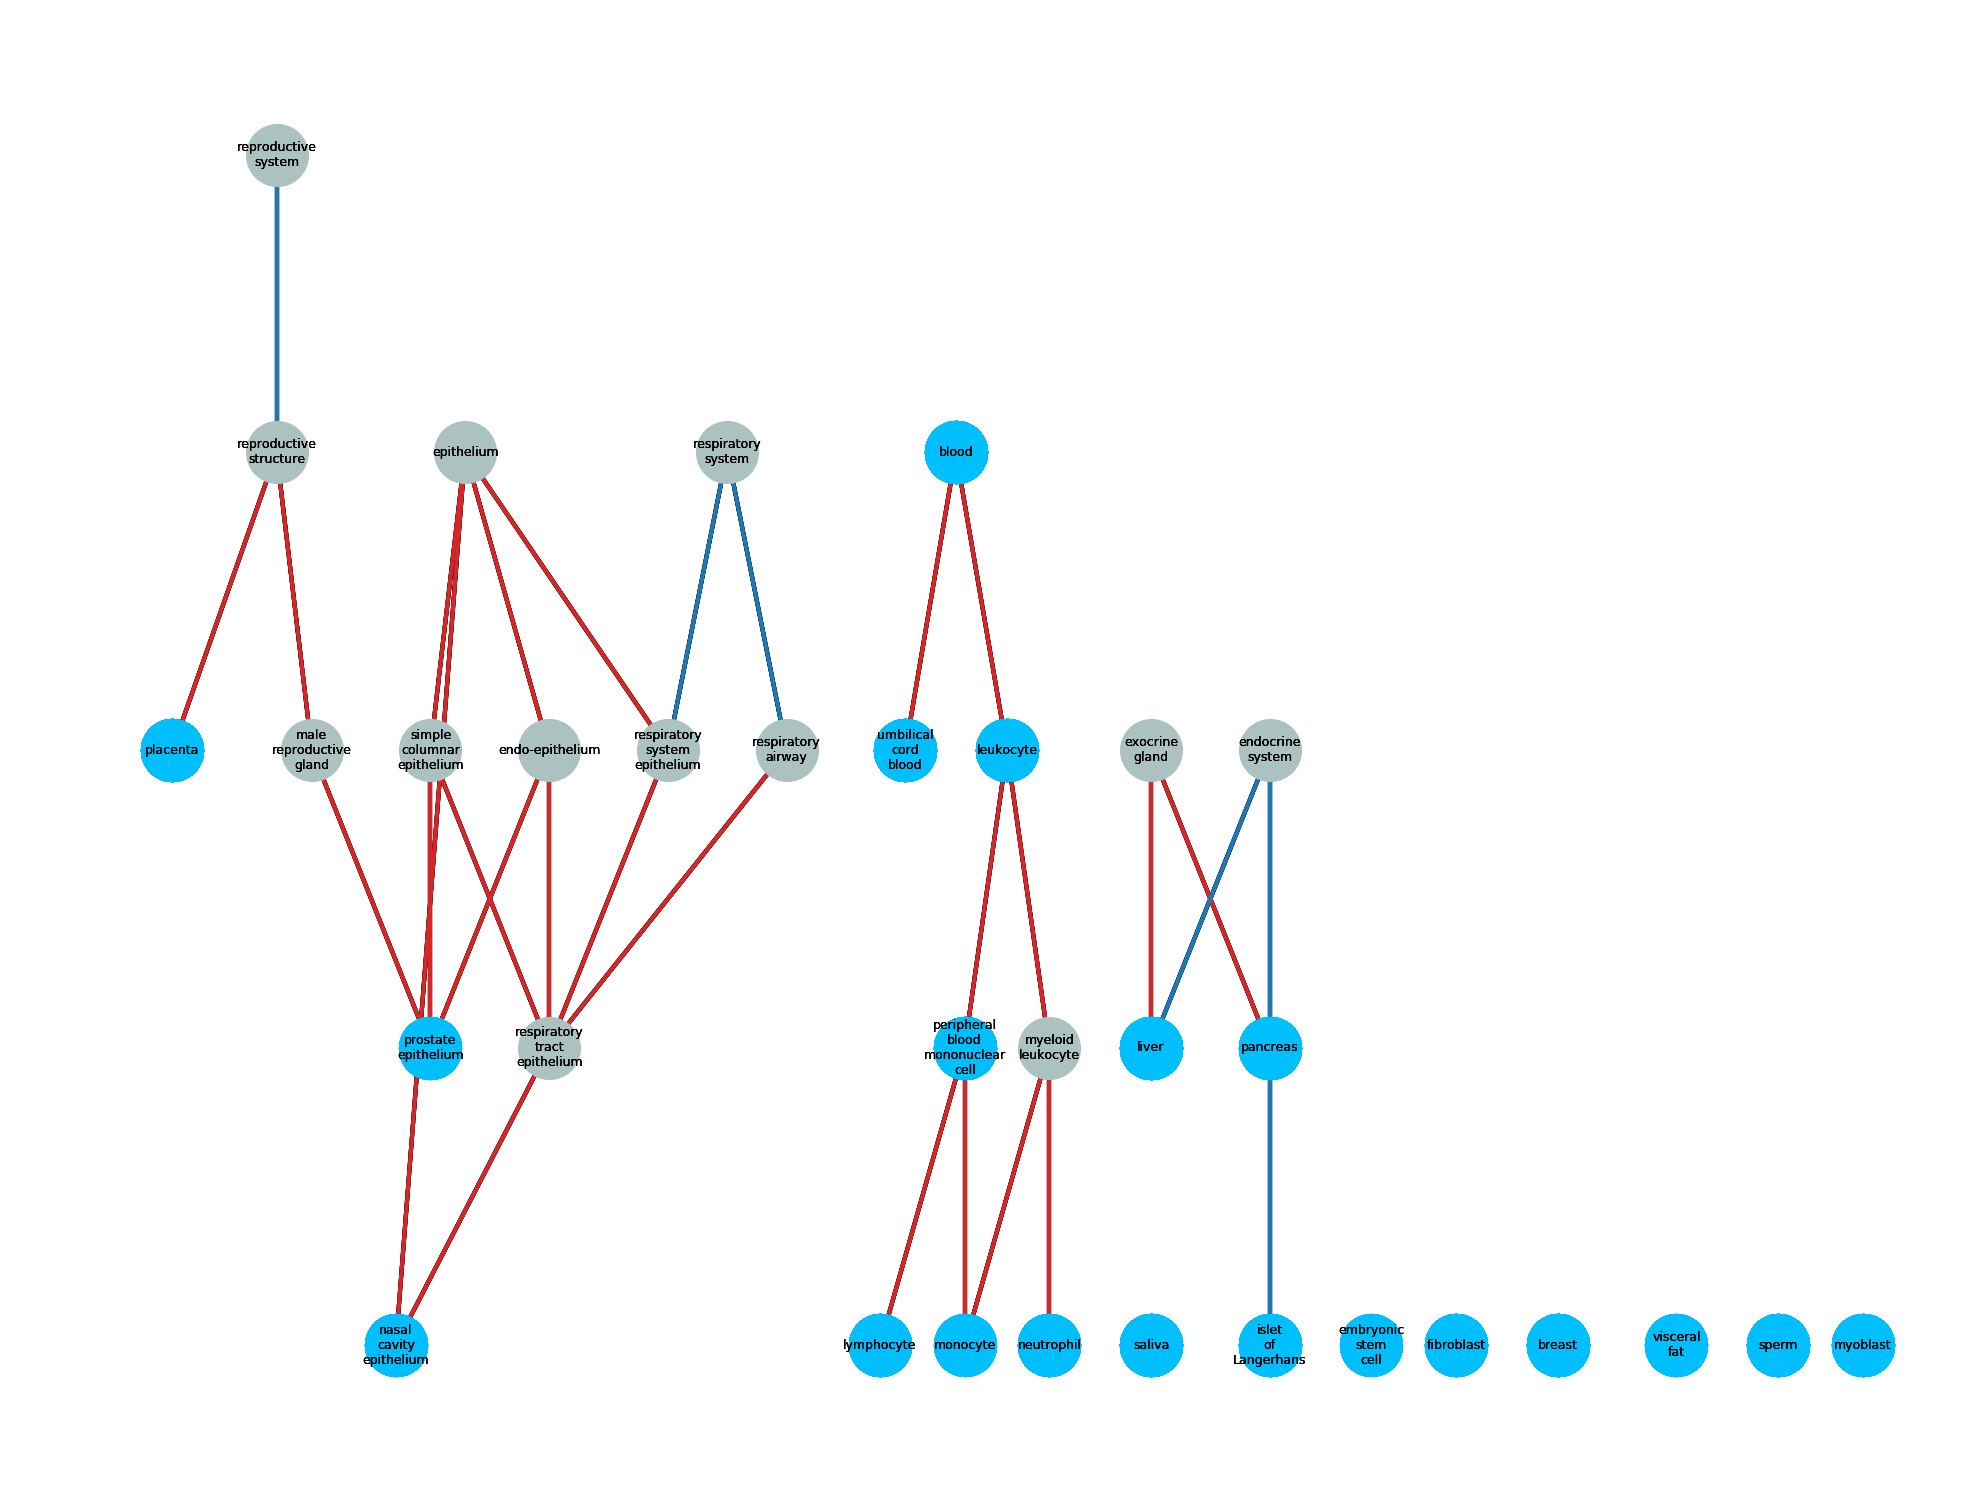

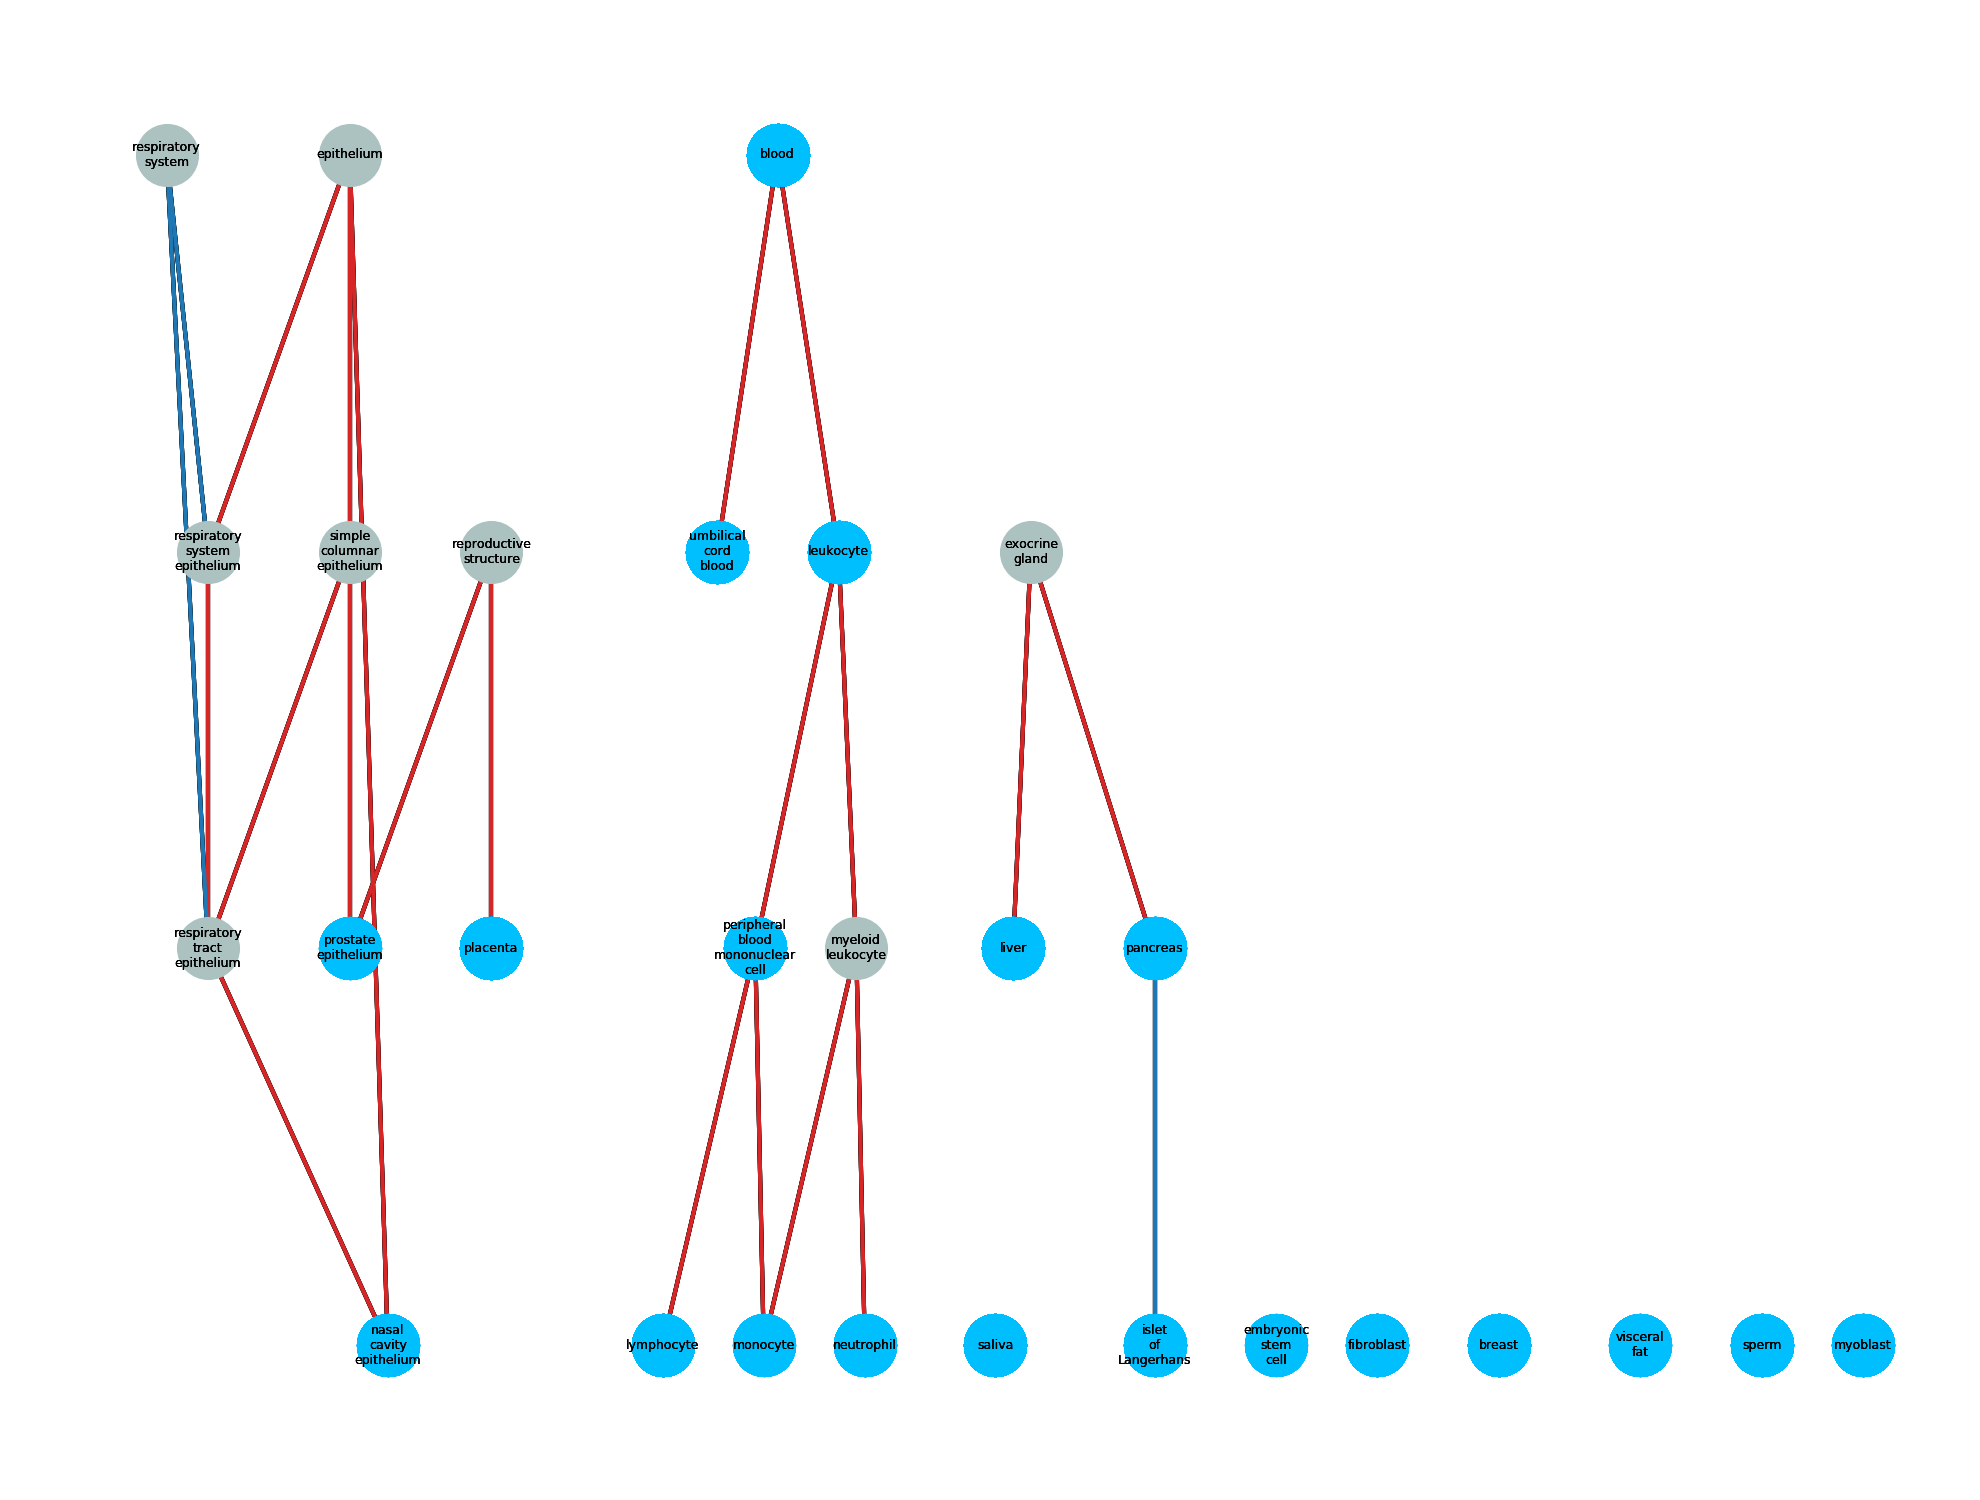

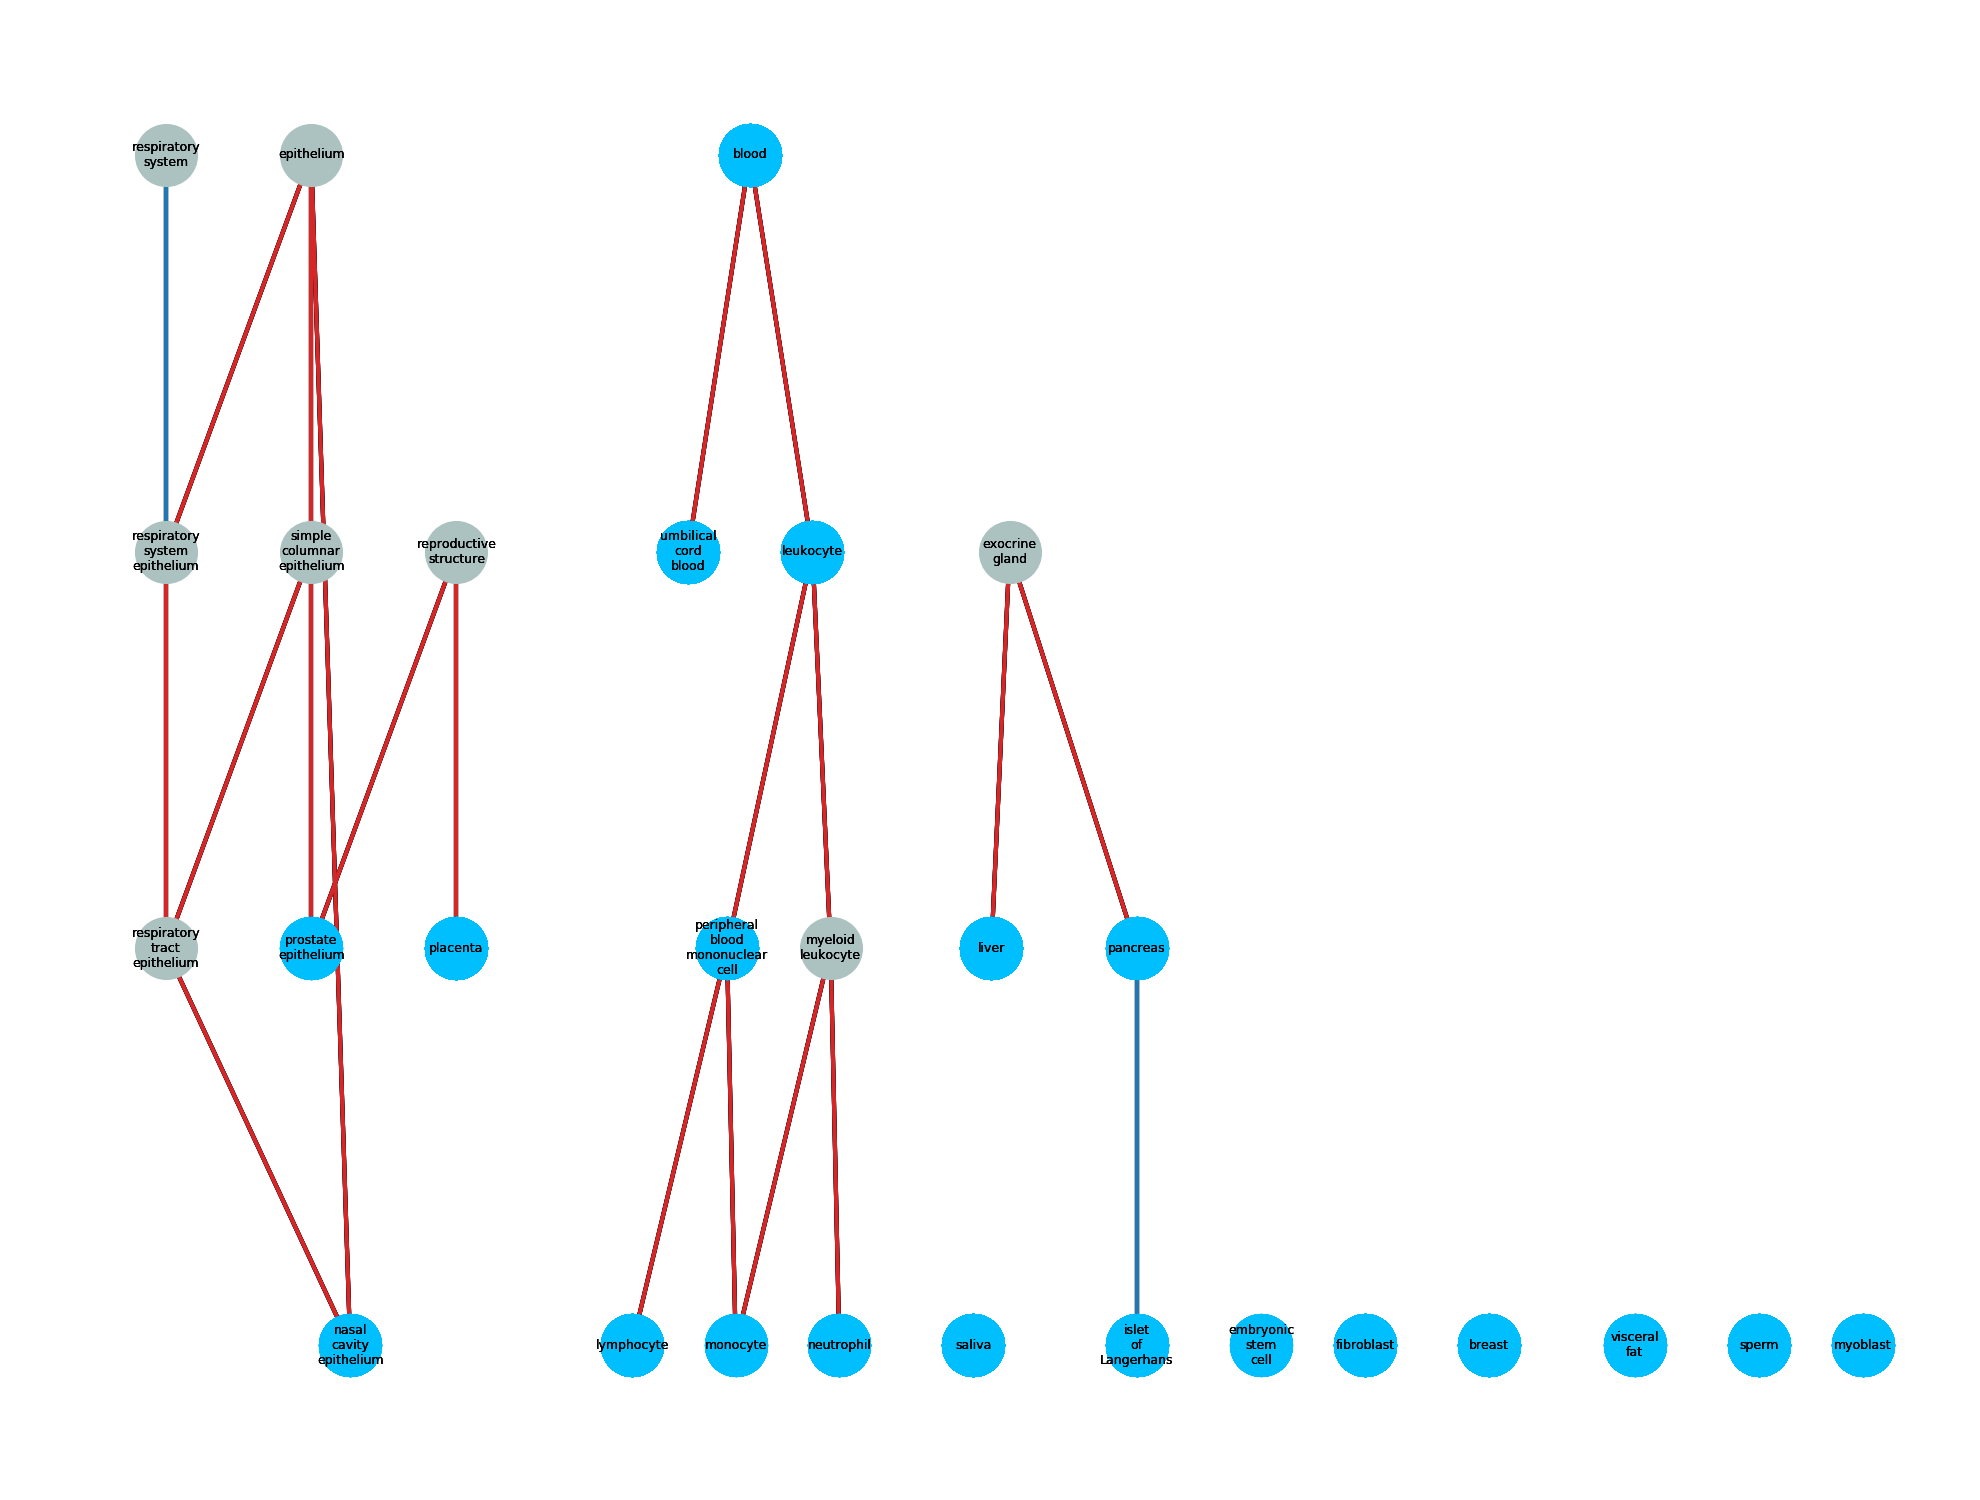

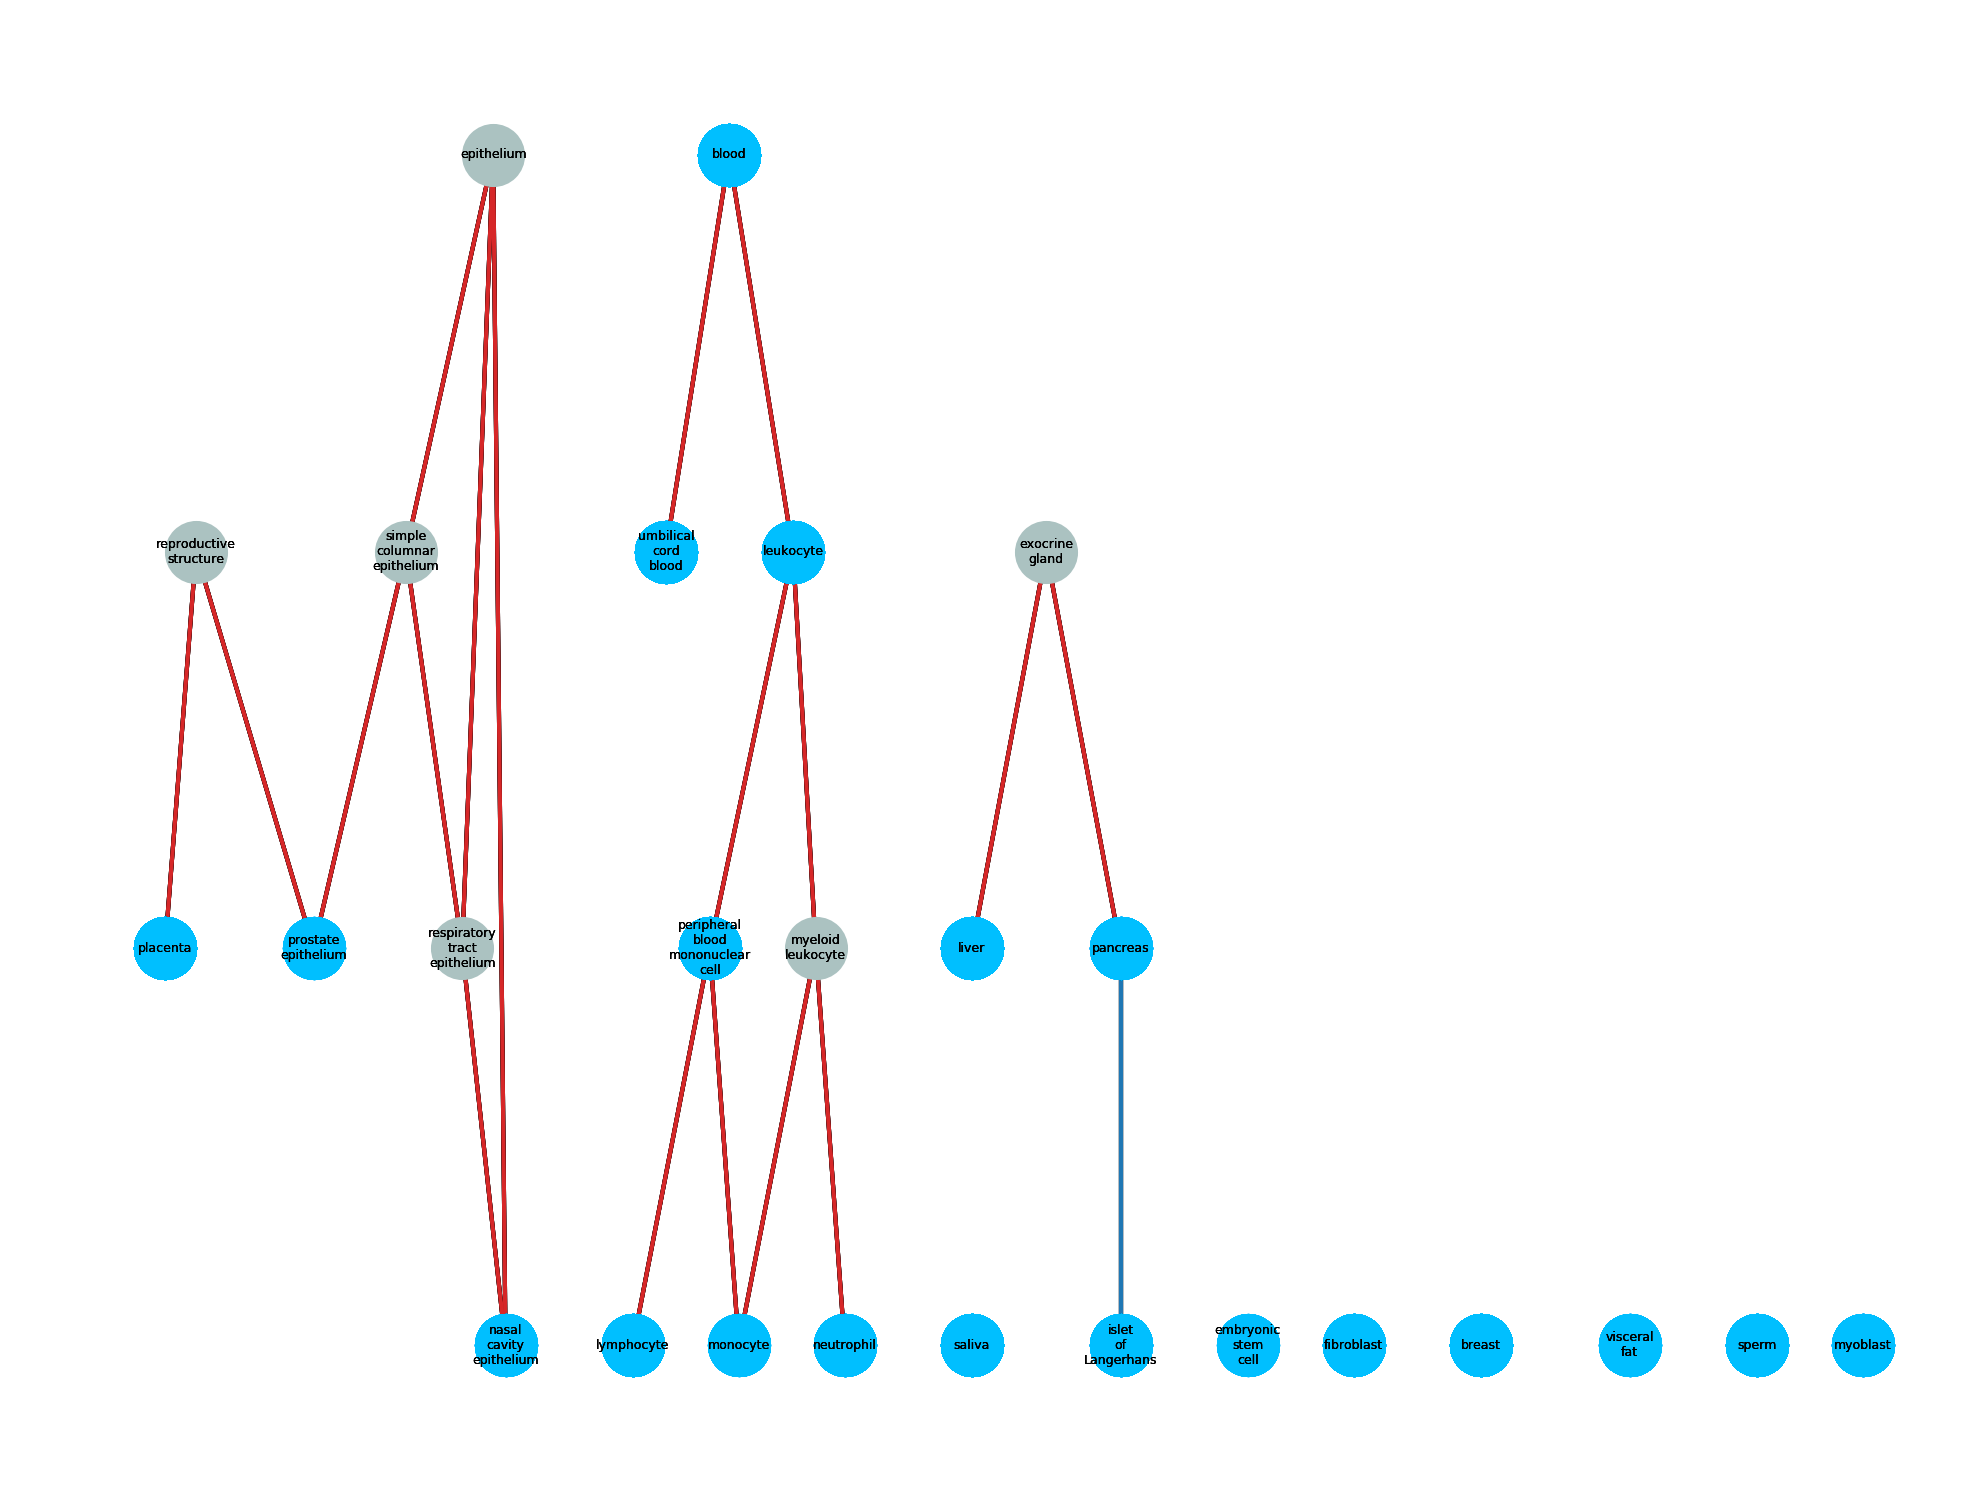

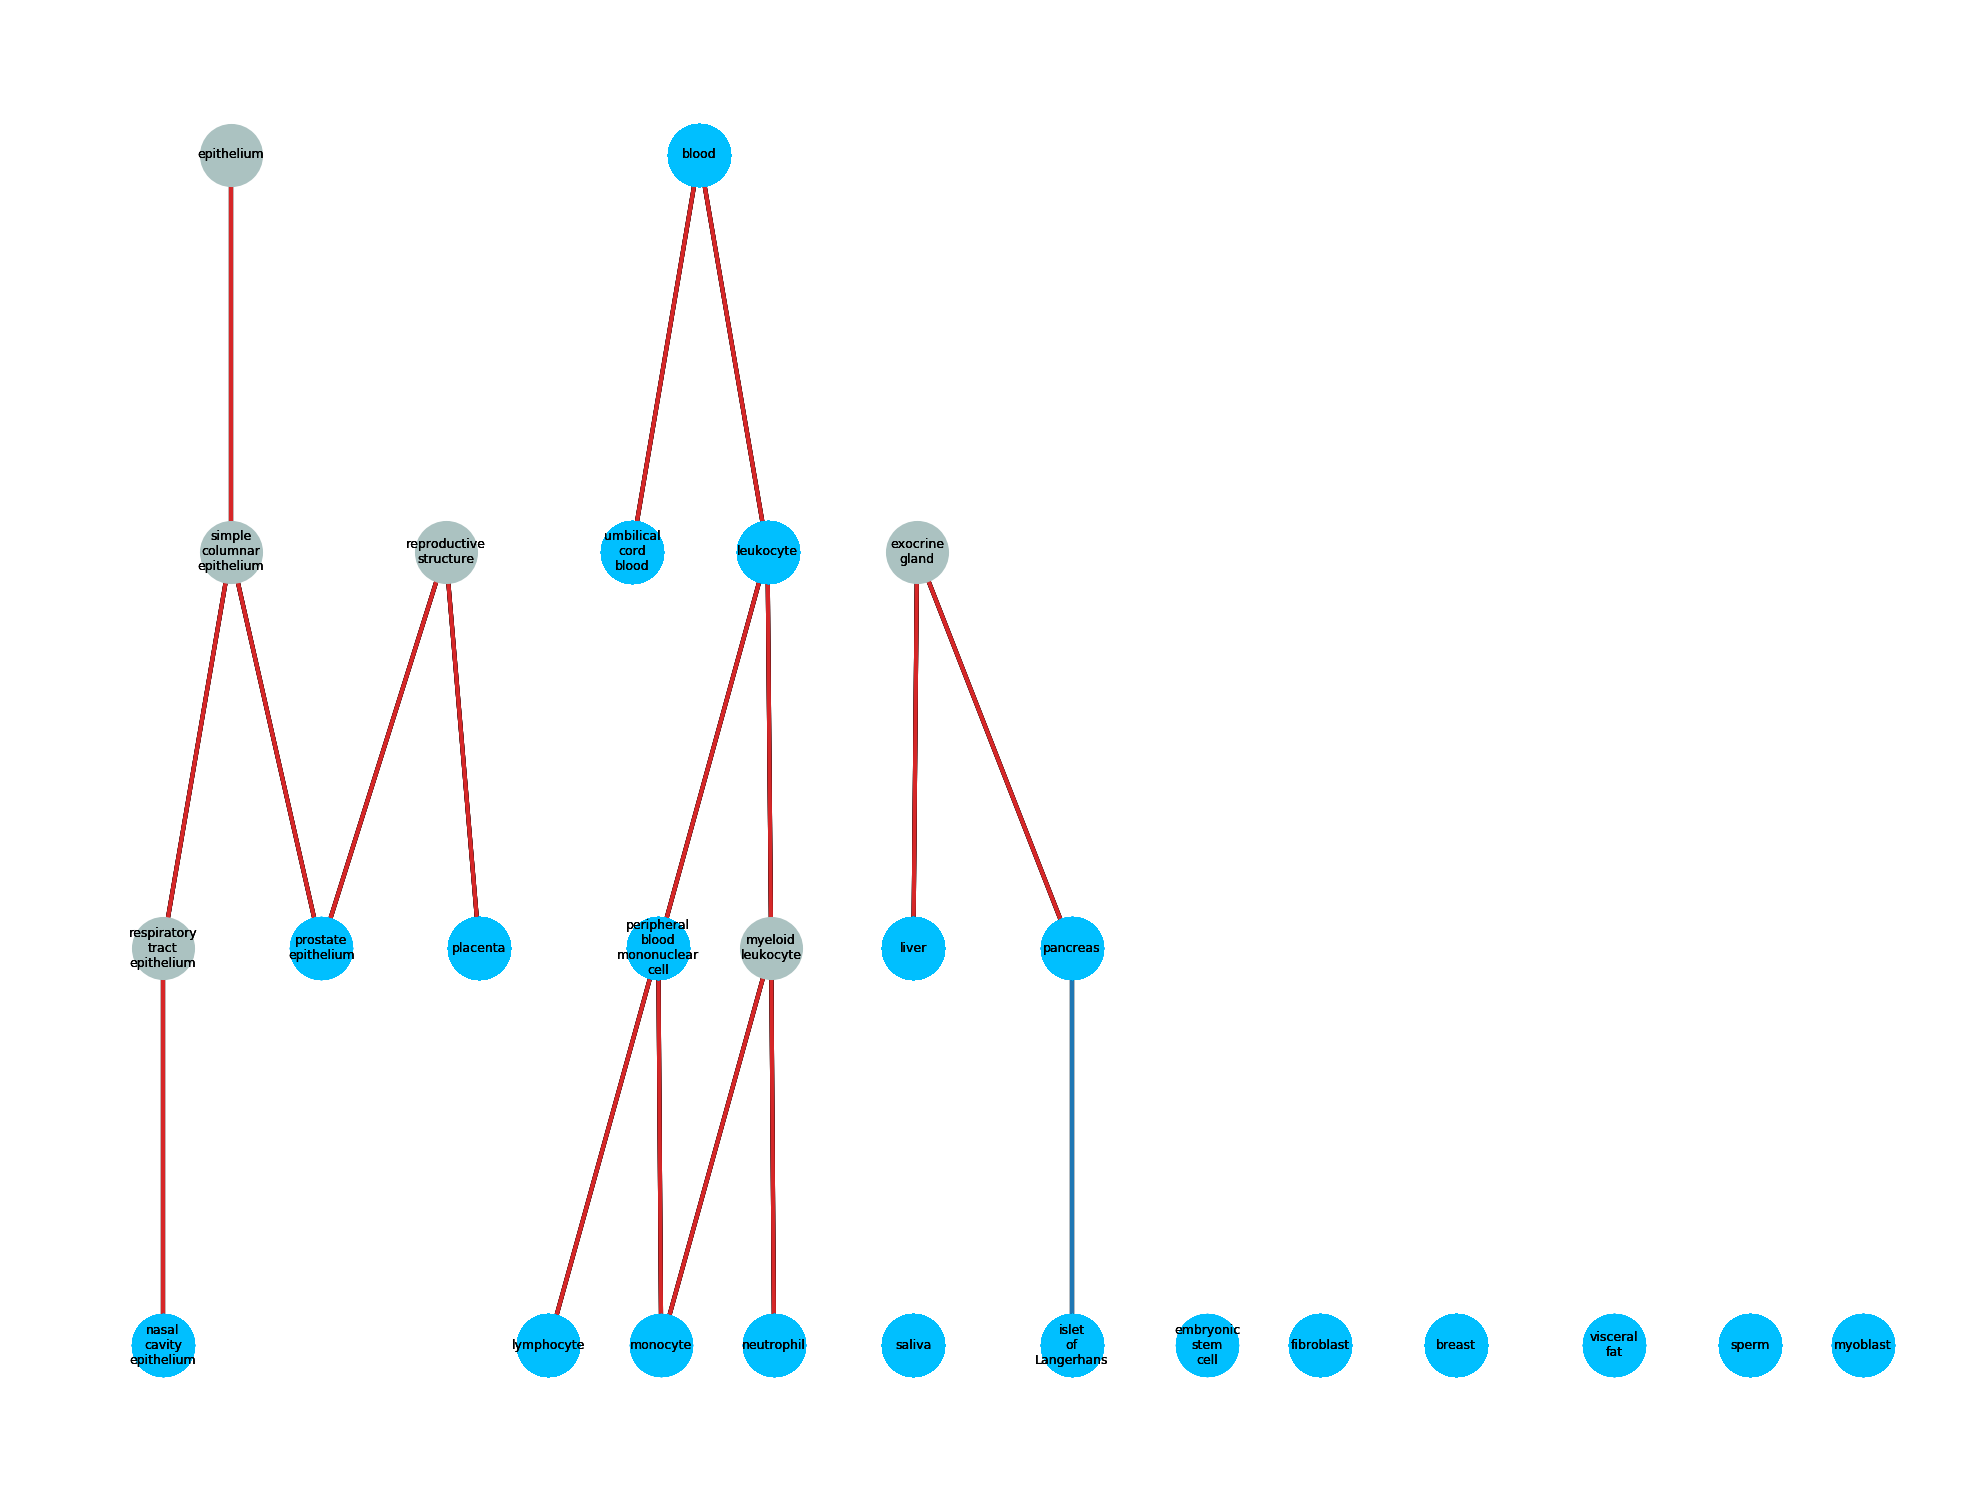

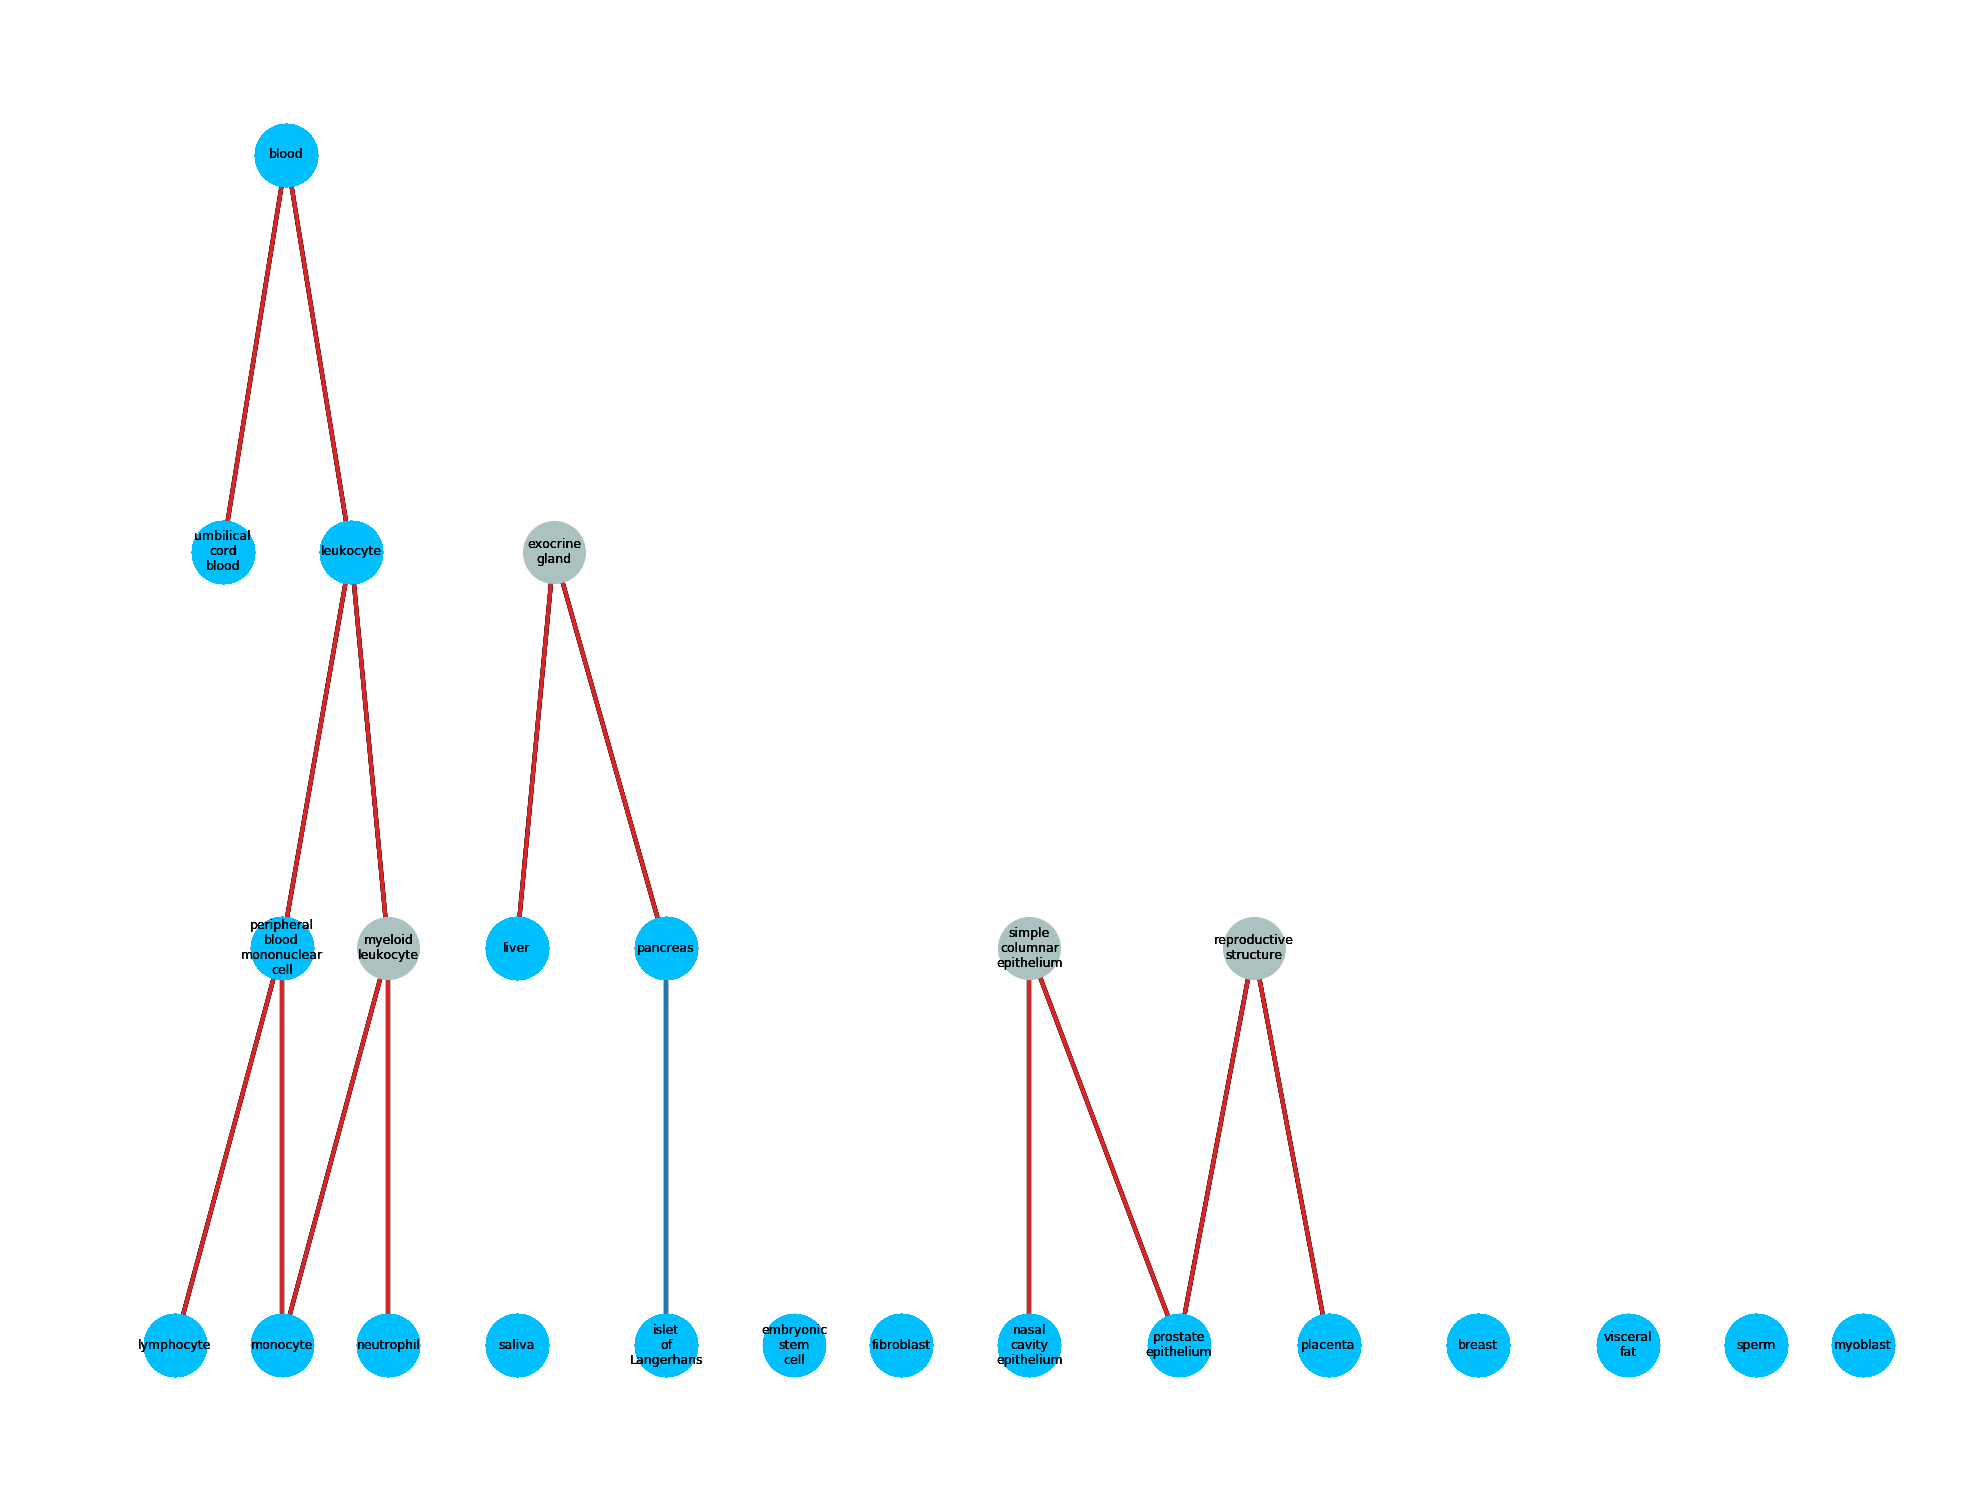

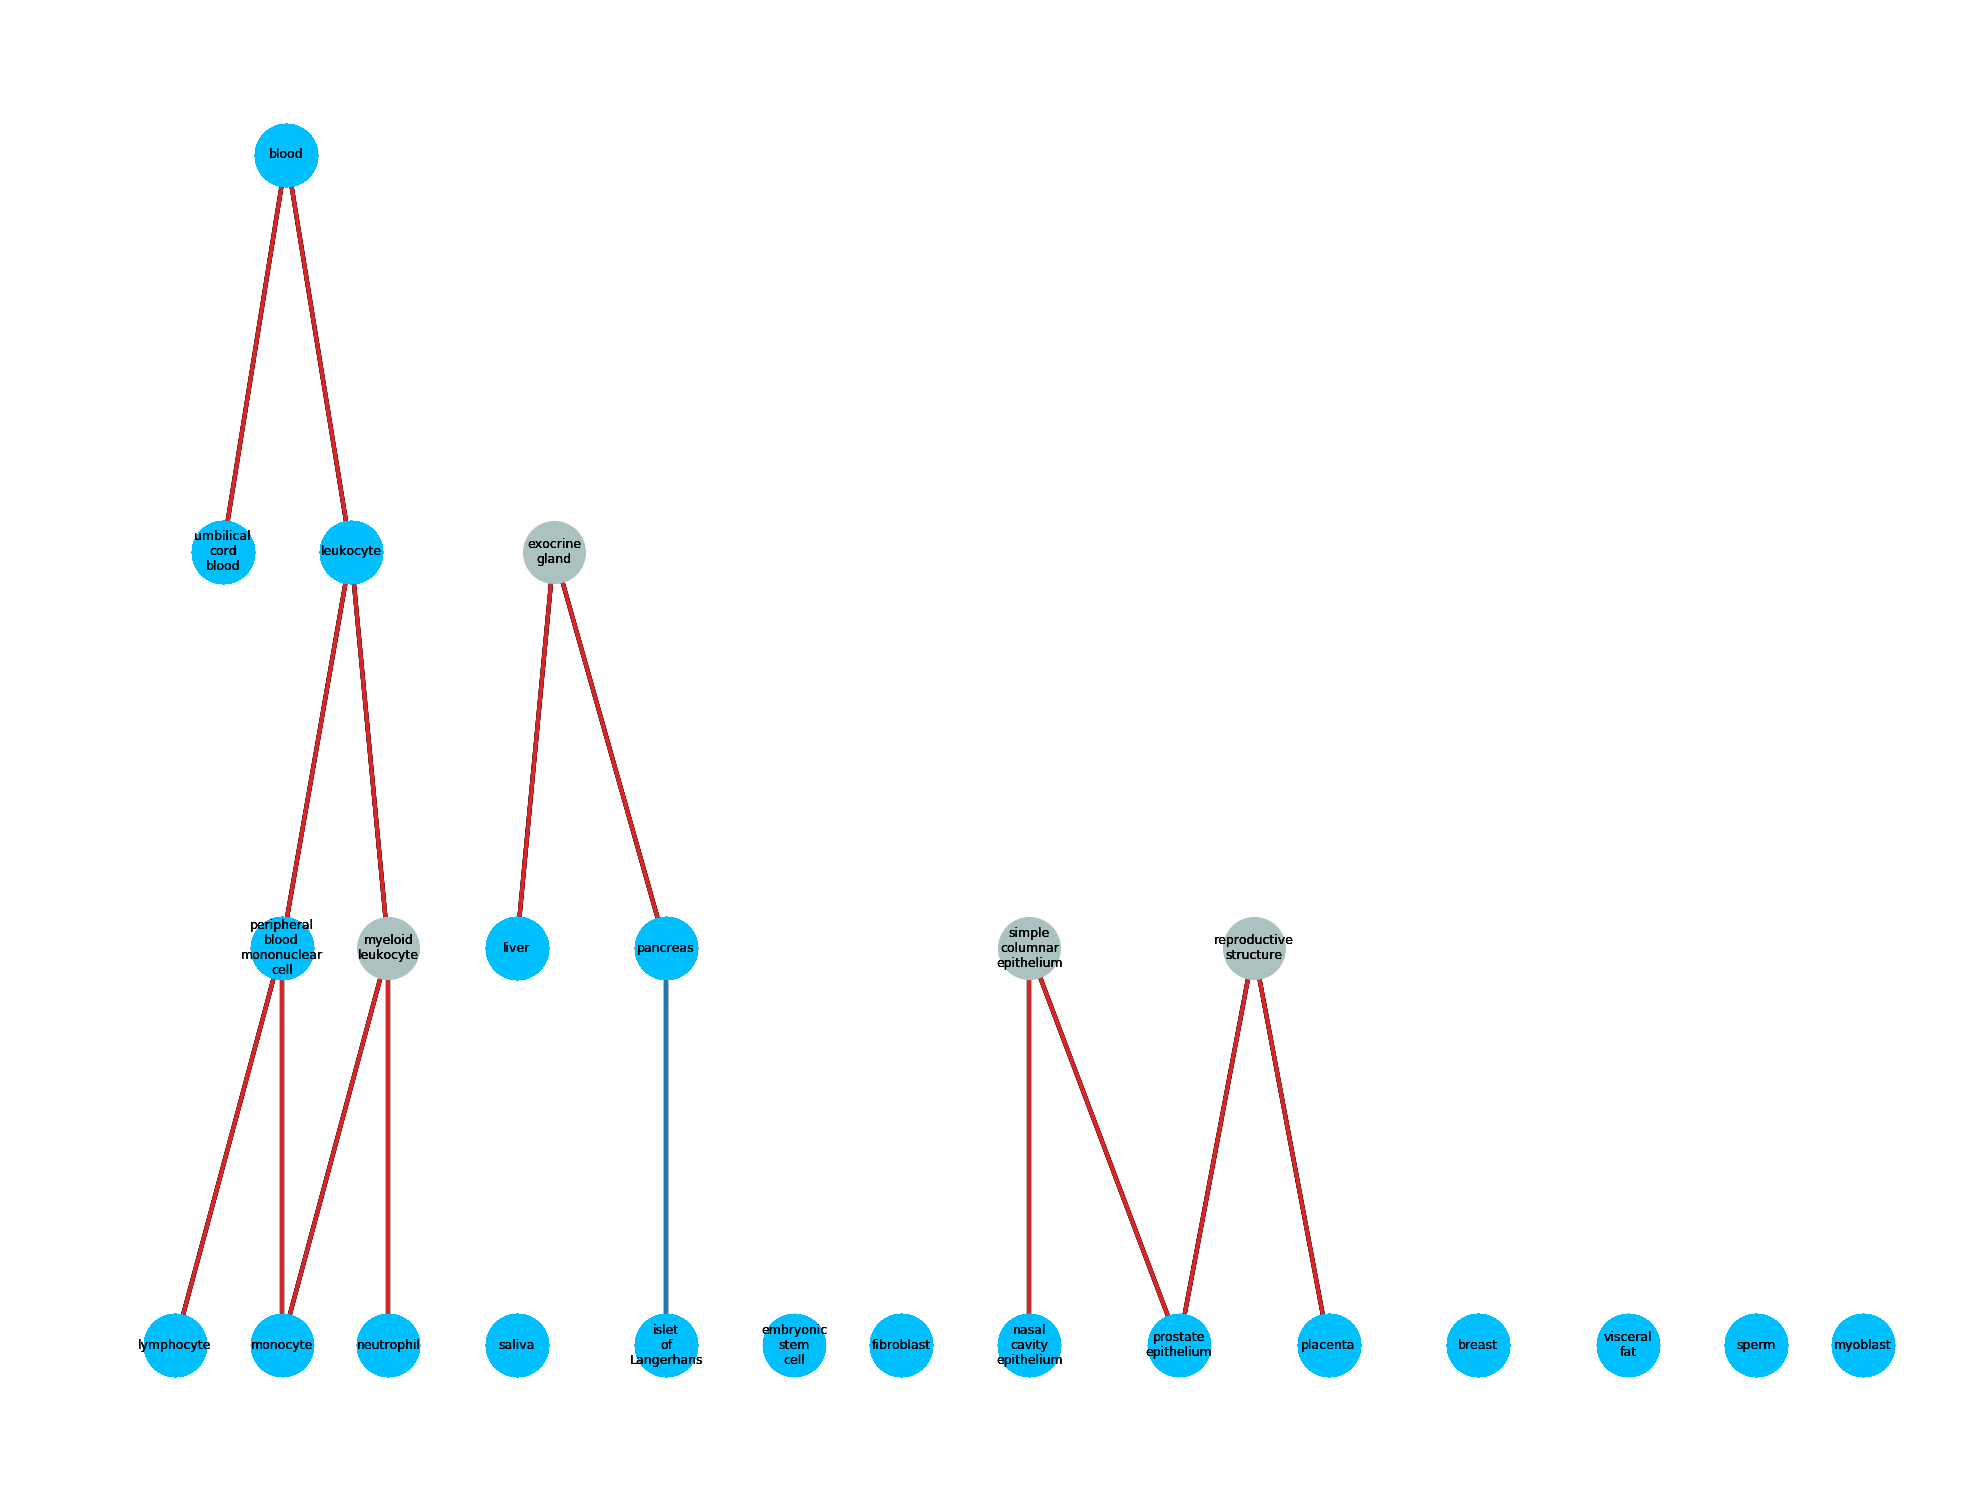

In [26]:
#get rid of it if 1 child + not wanted

unwanted_node=list()
for node in cut_tree.nodes:
    node_parents=list(cut_tree.successors(node))
    node_children=list(cut_tree.predecessors(node))
    if node in wanted_node: continue
    elif (len(node_children)==0): unwanted_node.extend([node])
    elif (len(node_parents)==0 and len(node_children)==1): unwanted_node.extend([node])
    elif (node not in wanted_node) and (len(node_parents)==0 and len(node_children)==0): unwanted_node.extend([node])
    
while (len(unwanted_node)>0):
    print(f'cut collapse: {len(unwanted_node)} nodes')
    cut_tree=cut_collapse(cut_tree, mult_meta['tissue_name'], wanted_node, unwanted_node)
    cut_tree=remove_triangle(cut_tree)
    cut_tree=nx.MultiDiGraph(collapse_same_children_same_parents(cut_tree))
    
    unwanted_node=list()
    for node in cut_tree.nodes:
        node_parents=list(cut_tree.successors(node))
        node_children=list(cut_tree.predecessors(node))
        if node in wanted_node: continue
        elif (len(node_children)==0): unwanted_node.extend([node])
        elif (len(node_parents)==0 and len(node_children)==1): unwanted_node.extend([node])
        elif (node not in wanted_node) and (len(node_parents)==0 and len(node_children)==0): unwanted_node.extend([node])
        
check_graph(cut_tree)

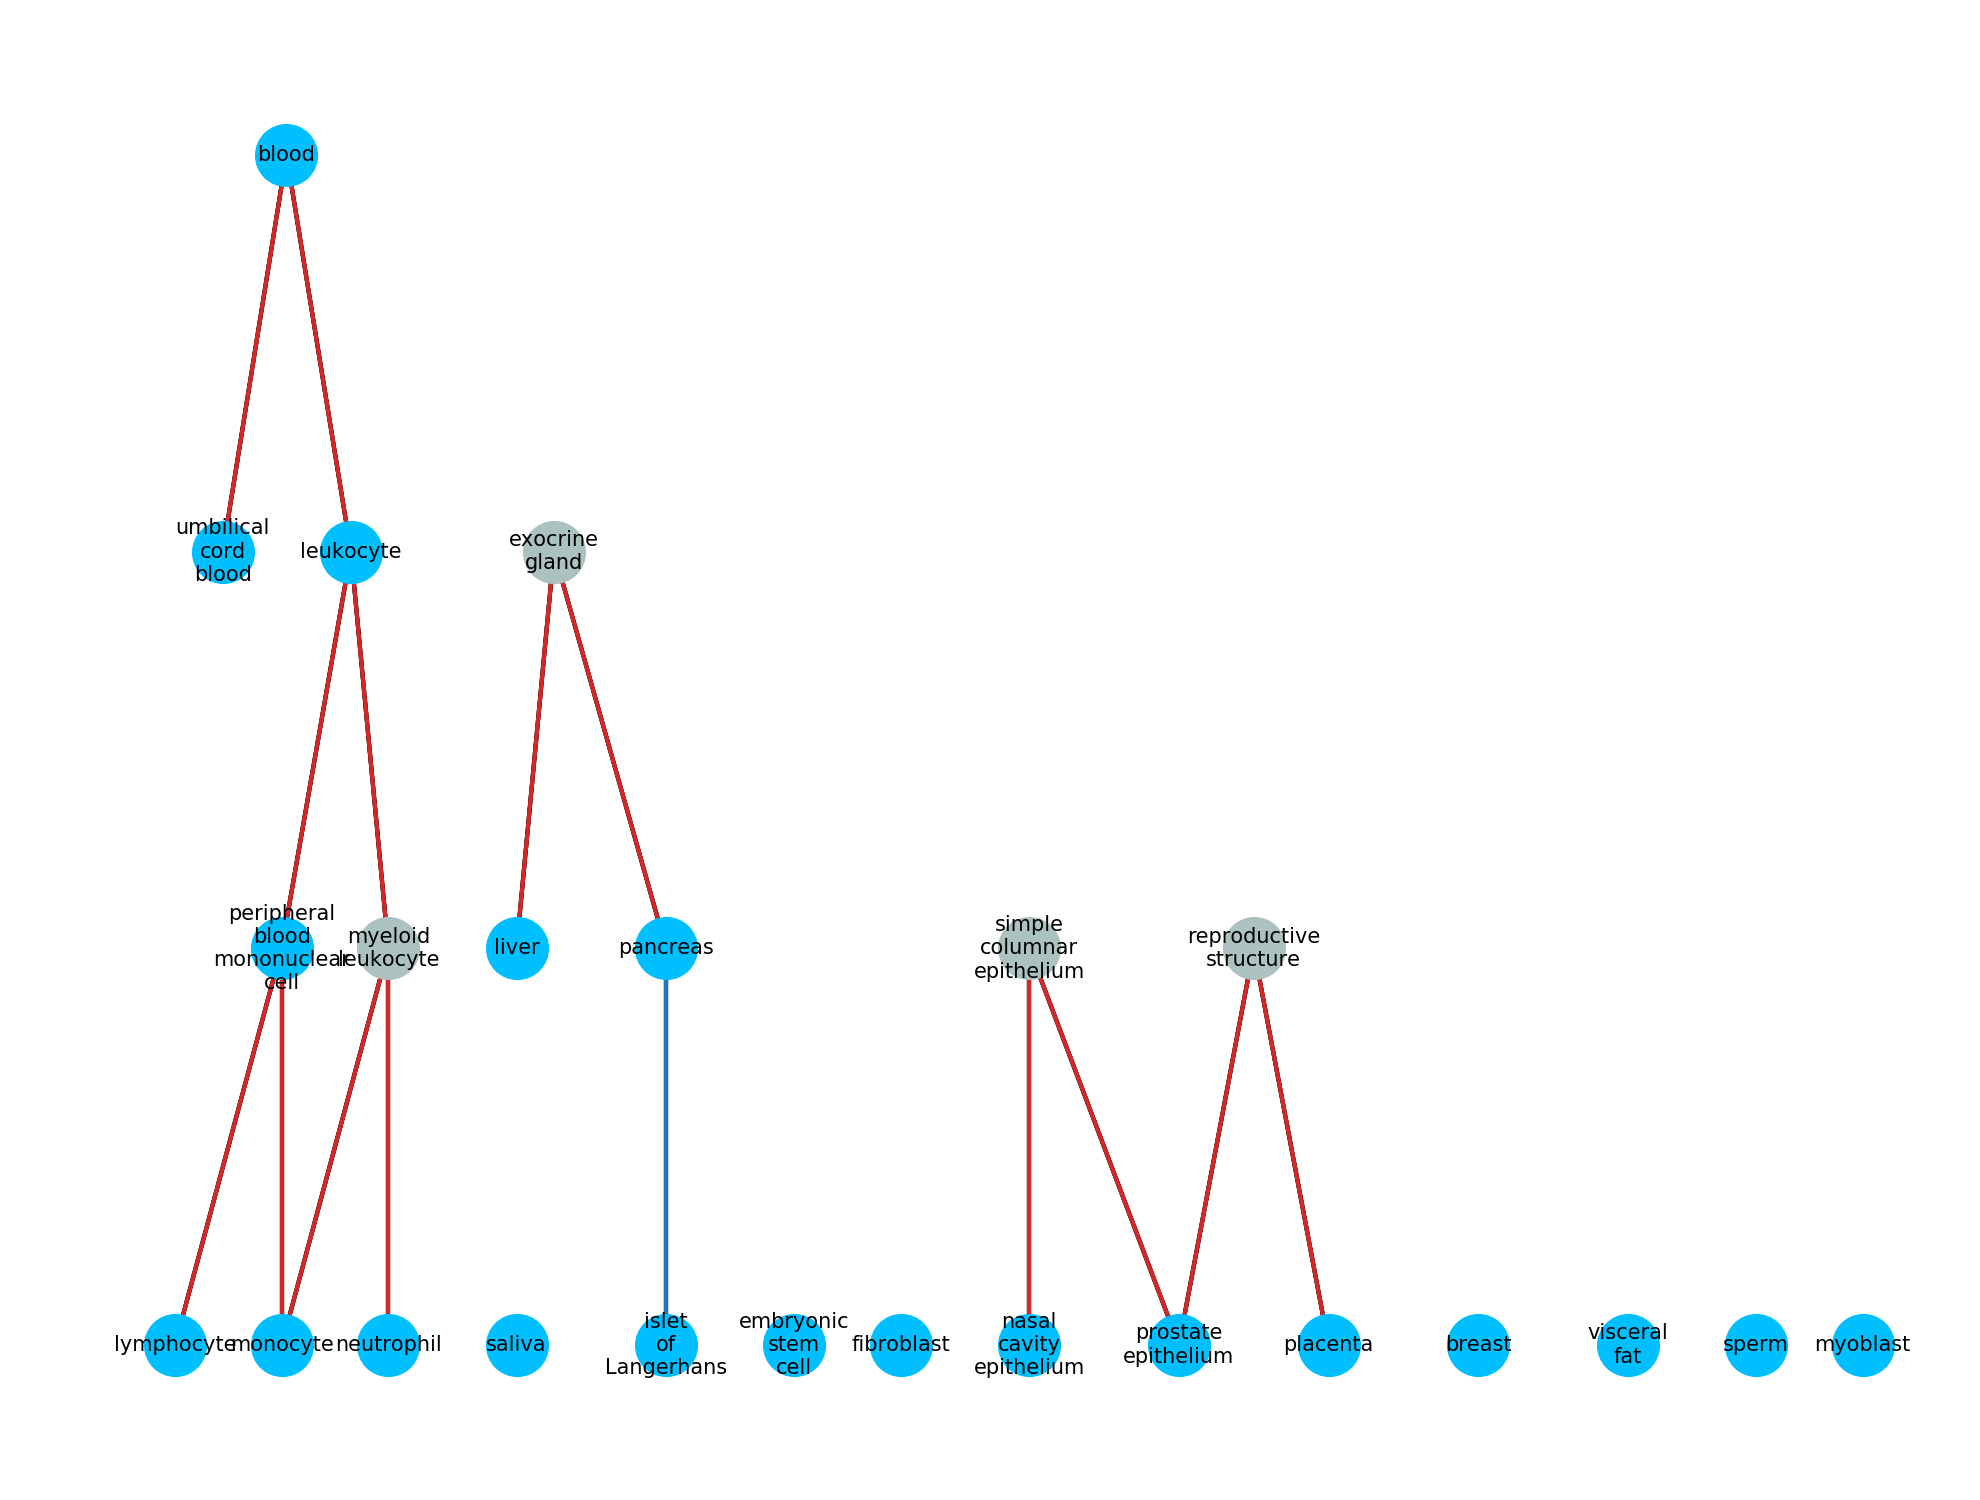

In [27]:
#display final
font_size = 5
sample_tree=cut_tree
sample_pos=graphviz_layout(sample_tree, prog='dot', root=name_to_id[root])
for key in sample_pos.keys():
    x,y=sample_pos[key]
    sample_pos[key]=(x,-y)
sample_label=dict((k, label_dict[k]) for k in list(sample_tree.nodes()) if k in label_dict)

meta_node=[name_to_id[x] for x in tissues if name_to_id[x] in sample_tree.nodes]
rest_node=[x for x in set(sample_tree.nodes)-set(meta_node)]

#display final structure
plt.figure(dpi=300)
nx.draw(sample_tree, sample_pos, nodelist=meta_node, node_color='#00bfff', labels=sample_label, with_labels=False, arrows=False, 
            font_size=font_size, node_size=node_size) # BLUE
nx.draw(sample_tree, sample_pos, nodelist=rest_node, node_color='#abc2c1', labels=sample_label, with_labels=False, arrows=False, 
            font_size=font_size, node_size=node_size) # GREY
nx.draw_networkx_edges(
    sample_tree,
    sample_pos,
    edgelist=[e for e in sample_tree.edges() if 'is_a' in sample_tree.get_edge_data(e[0], e[1])],
    width=1,
    alpha=1,
    edge_color="tab:red",
arrows=False)
nx.draw_networkx_edges(
    sample_tree,
    sample_pos,
    edgelist=[e for e in sample_tree.edges() if 'part_of' in sample_tree.get_edge_data(e[0], e[1])],
    width=1,
    alpha=1,
    edge_color="tab:blue",
arrows=False)

text = nx.draw_networkx_labels(sample_tree, sample_pos, labels=sample_label,font_size=font_size)
for _, t in text.items():
    t.set_rotation('horizontal') 

None

In [28]:
[id_to_name[k] for k, v in sorted(sample_pos.items(), key=lambda item: item[1])]

['lymphocyte',
 'umbilical cord blood',
 'monocyte',
 'peripheral blood mononuclear cell',
 'blood',
 'leukocyte',
 'neutrophil',
 'myeloid leukocyte',
 'saliva',
 'liver',
 'exocrine gland',
 'islet of Langerhans',
 'pancreas',
 'embryonic stem cell',
 'fibroblast',
 'nasal cavity epithelium',
 'simple columnar epithelium',
 'prostate epithelium',
 'reproductive structure',
 'placenta',
 'breast',
 'visceral fat',
 'sperm',
 'myoblast']

In [29]:
[tissues[x] for x in np.argsort(sample_pos)]

['placenta']

In [30]:
normal_meta['tissue_name'].value_counts()

blood                                855
placenta                             326
breast                               161
liver                                147
saliva                               131
lymphocyte                           131
leukocyte                            103
sperm                                101
fibroblast                            94
umbilical cord blood                  92
peripheral blood mononuclear cell     88
islet of Langerhans                   69
neutrophil                            60
pancreas                              57
myoblast                              56
nasal cavity epithelium               41
visceral fat                          33
prostate epithelium                   23
monocyte                              21
embryonic stem cell                   15
Name: tissue_name, dtype: int64

In [31]:
save_dill = False
save_file = False

date = "sep2024"

sample_meta=mult_meta[mult_meta['tissue_name'].isin([id_to_name[x] for x in sample_tree.nodes()])]
print(sample_meta.shape)

if save_dill:
    with open(f"uberon_{date}_atleast{atleast}", "wb") as dill_file:
        dill.dump([sample_tree, sample_meta, sample_pos], dill_file)
if save_file:
    with open(f"uberon_{date}_atleast{atleast}_adjlist", "wb") as file:
        nx.write_multiline_adjlist(sample_tree, file)

# if save_dill:
#     with open(f"uberon_{date}_all", "wb") as dill_file:
#         dill.dump([sample_tree, sample_meta, sample_pos], dill_file)
# if save_file:
#     with open(f"uberon_{date}_all_adjlist", "wb") as file:
#         nx.write_multiline_adjlist(sample_tree, file)

(2604, 7)


### same positive same netural

24
0


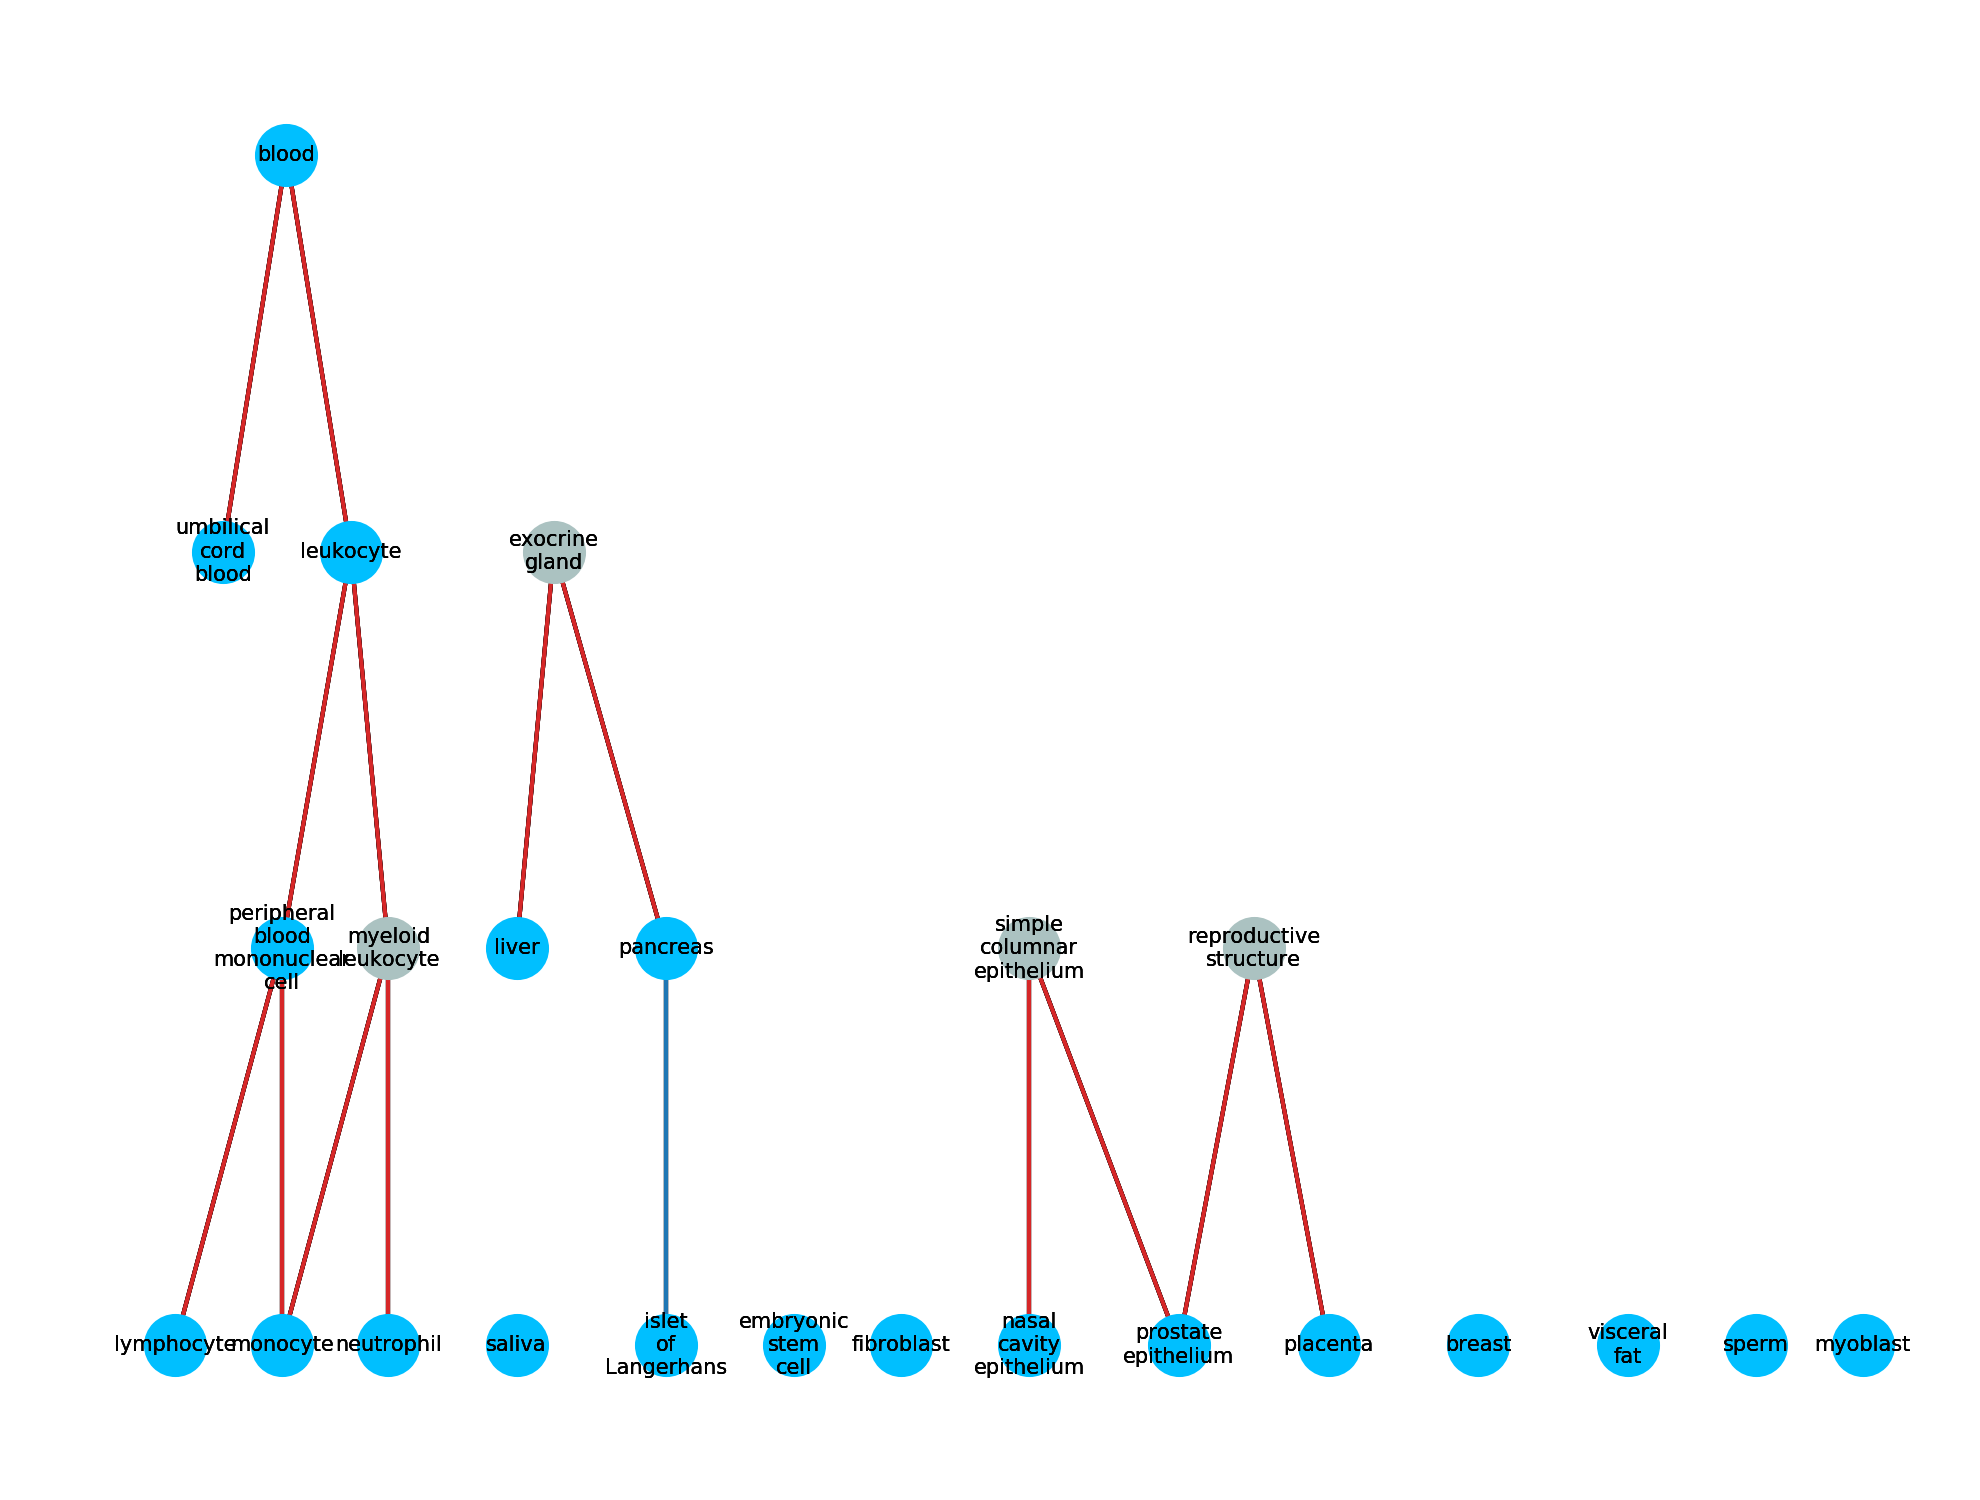

In [32]:
spsn=collapse_same_pos_same_neut(sample_tree, mult_meta['tissue_name'].values)
[id_to_name[x] for x in spsn.keys()]

sample_tree=cut_tree
sample_pos=graphviz_layout(sample_tree, prog='dot', root=name_to_id[root])
for key in sample_pos.keys():
    x,y=sample_pos[key]
    sample_pos[key]=(x,-y)
sample_label=dict((k, label_dict[k]) for k in list(sample_tree.nodes()) if k in label_dict)

meta_node=[name_to_id[x] for x in tissues if name_to_id[x] in sample_tree.nodes]
rest_node=[x for x in set(sample_tree.nodes)-set(meta_node)]
spsn_node=spsn.keys()

#display final structure
plt.figure(dpi=300)
nx.draw(sample_tree, sample_pos, nodelist=meta_node, node_color='#00bfff', labels=sample_label, with_labels=True, arrows=False, 
            font_size=font_size, node_size=node_size) # BLUE
nx.draw(sample_tree, sample_pos, nodelist=rest_node, node_color='#abc2c1', labels=sample_label, with_labels=True, arrows=False, 
            font_size=font_size, node_size=node_size) # GREY
nx.draw(sample_tree, sample_pos, nodelist=spsn_node, node_color='#FFA500', labels=sample_label, with_labels=True, arrows=False, 
            font_size=font_size, node_size=node_size) # ORANGE
nx.draw_networkx_edges(
    sample_tree,
    sample_pos,
    edgelist=[e for e in sample_tree.edges() if 'is_a' in sample_tree.get_edge_data(e[0], e[1])],
    width=1,
    alpha=1,
    edge_color="tab:red",
arrows=False)
nx.draw_networkx_edges(
    sample_tree,
    sample_pos,
    edgelist=[e for e in sample_tree.edges() if 'part_of' in sample_tree.get_edge_data(e[0], e[1])],
    width=1,
    alpha=1,
    edge_color="tab:blue",
arrows=False)

# text = nx.draw_networkx_labels(sample_tree, sample_pos, labels=sample_label,font_size=font_size)
# for _, t in text.items():
#     t.set_rotation('vertical') 

print(len(sample_tree))
print(len(spsn))

In [33]:
# [tissues[x] for x in np.argsort(x_pos)]

### color by number

In [34]:
# counts = Counter(normal_meta.tissue_name)
# counts = {name_to_id[key]: value for key,value in counts.items()}

In [35]:
# #display final
# font_size = 10
# node_size = 500
# sample_tree=cut_tree
# sample_pos=graphviz_layout(sample_tree, prog='dot', root=name_to_id[root])
# for key in sample_pos.keys():
#     x,y=sample_pos[key]
#     sample_pos[key]=(y,-x)
# sample_label=dict((k, label_dict[k]) for k in list(sample_tree.nodes()) if k in label_dict)

# meta_node=[name_to_id[x] for x in tissues if name_to_id[x] in sample_tree.nodes]
# rest_node=[x for x in set(sample_tree.nodes)-set(meta_node)]

# node_color = [counts[node] for node in meta_node]

# #display final structure
# plt.figure(figsize=(7, 9))
# n = nx.draw(sample_tree, sample_pos, 
#             nodelist=meta_node, 
#             node_color=node_color, 
#             labels=sample_label, with_labels=False, arrows=False, 
#             font_size=font_size, node_size=node_size, cmap = "Wistia") # BLUE
# ax=plt.gca()
# PCM=ax.get_children()[0] # this index may vary
# cbar = plt.colorbar(PCM, ax=ax, shrink=0.5)
# cbar.ax.tick_params(labelsize=10)

# nx.draw(sample_tree, sample_pos, 
#         nodelist=rest_node, node_color='#abc2c1', 
#         labels=sample_label, with_labels=False, arrows=False, 
#         font_size=font_size, node_size=node_size) # GREY
# nx.draw_networkx_edges(
#     sample_tree,
#     sample_pos,
#     edgelist=[e for e in sample_tree.edges() if 'is_a' in sample_tree.get_edge_data(e[0], e[1])],
#     width=1,
#     alpha=1,
#     # edge_color="tab:red",
# arrows=False)
# nx.draw_networkx_edges(
#     sample_tree,
#     sample_pos,
#     edgelist=[e for e in sample_tree.edges() if 'part_of' in sample_tree.get_edge_data(e[0], e[1])],
#     width=1,
#     alpha=1,
#     # edge_color="tab:blue",
# arrows=False)

# text = nx.draw_networkx_labels(sample_tree, sample_pos, labels=sample_label,font_size=font_size)
# # for _, t in text.items():
# #     t.set_rotation('vertical') 

# save = False

# if save:
#     plt.savefig("./../figures/ontology_samplesize_vertical.png", bbox_inches='tight')

In [36]:
# #display final
# font_size = 10
# node_size = 500
# sample_tree=cut_tree
# sample_pos=graphviz_layout(sample_tree, prog='dot', root=name_to_id[root])
# for key in sample_pos.keys():
#     x,y=sample_pos[key]
#     sample_pos[key]=(x,-y)
# sample_label=dict((k, label_dict[k]) for k in list(sample_tree.nodes()) if k in label_dict)

# meta_node=[name_to_id[x] for x in tissues if name_to_id[x] in sample_tree.nodes]
# rest_node=[x for x in set(sample_tree.nodes)-set(meta_node)]

# node_color = [counts[node] for node in meta_node]

# #display final structure
# plt.figure(figsize=(22, 5))
# n = nx.draw(sample_tree, sample_pos, 
#             nodelist=meta_node, 
#             node_color=node_color, 
#             labels=sample_label, with_labels=False, arrows=False, 
#             font_size=font_size, node_size=node_size, cmap = "Wistia") # BLUE
# ax=plt.gca()
# PCM=ax.get_children()[0] # this index may vary
# cbar = plt.colorbar(PCM, ax=ax, shrink=0.5)
# cbar.ax.tick_params(labelsize=10)

# nx.draw(sample_tree, sample_pos, 
#         nodelist=rest_node, node_color='#abc2c1', 
#         labels=sample_label, with_labels=False, arrows=False, 
#         font_size=font_size, node_size=node_size) # GREY
# nx.draw_networkx_edges(
#     sample_tree,
#     sample_pos,
#     edgelist=[e for e in sample_tree.edges() if 'is_a' in sample_tree.get_edge_data(e[0], e[1])],
#     width=1,
#     alpha=1,
#     # edge_color="tab:red",
# arrows=False)
# nx.draw_networkx_edges(
#     sample_tree,
#     sample_pos,
#     edgelist=[e for e in sample_tree.edges() if 'part_of' in sample_tree.get_edge_data(e[0], e[1])],
#     width=1,
#     alpha=1,
#     # edge_color="tab:blue",
# arrows=False)

# text = nx.draw_networkx_labels(sample_tree, sample_pos, labels=sample_label,font_size=font_size)
# # for _, t in text.items():
# #     t.set_rotation('vertical') 

# save = False

# if save:
#     plt.savefig("./../figures/ontology_samplesize_horizontal.png", bbox_inches='tight')

## add root

In [37]:
def add_root(g, g_pos):
    component_tops = list()
    # print([c for c in nx.weakly_connected_components(g)])
    if len([x for x in nx.weakly_connected_components(g)])==1:
        core = [id_to_name[x] for x in g.nodes() if 'subset' in g.nodes(data=True)[x] and 'vertebrate_core' in g.nodes(data=True)[x]['subset']]
        component_tops = [id_to_name[x] for x in g.nodes() if id_to_name[x].split()[-1]=='system' and x in g.nodes()]
        component_tops = [x for x in g.nodes() if id_to_name[x].split()[-1]=='system' and x in g.nodes()]
        # component_tops = [name_to_id[x] for x in list(set(core) & set(system_nodes)) if name_to_id[x] in g.nodes()]
        # component_tops = [n for n,c in ordered_nodes if id_to_name[n] in system_nodes and c>10]
    else:
        for comp in  nx.weakly_connected_components(g):
            comp_pos = {key: value for key, value in g_pos.items() if key in comp}       
            comp_max_y_list = [k for k, v in comp_pos.items() if v[1] == max(comp_pos.values(), key=lambda x: x[1])[1]]
            component_tops.extend(comp_max_y_list)
    print([id_to_name[x] for x in component_tops])
    
    g.add_node('root')
    [g.add_edge('root', node) for node in component_tops]
    
    return g, g_pos

rooted_tree, rooted_pos = add_root(sample_tree.copy(), copy.copy(sample_pos))

['blood', 'saliva', 'exocrine gland', 'embryonic stem cell', 'fibroblast', 'simple columnar epithelium', 'reproductive structure', 'breast', 'visceral fat', 'sperm', 'myoblast']


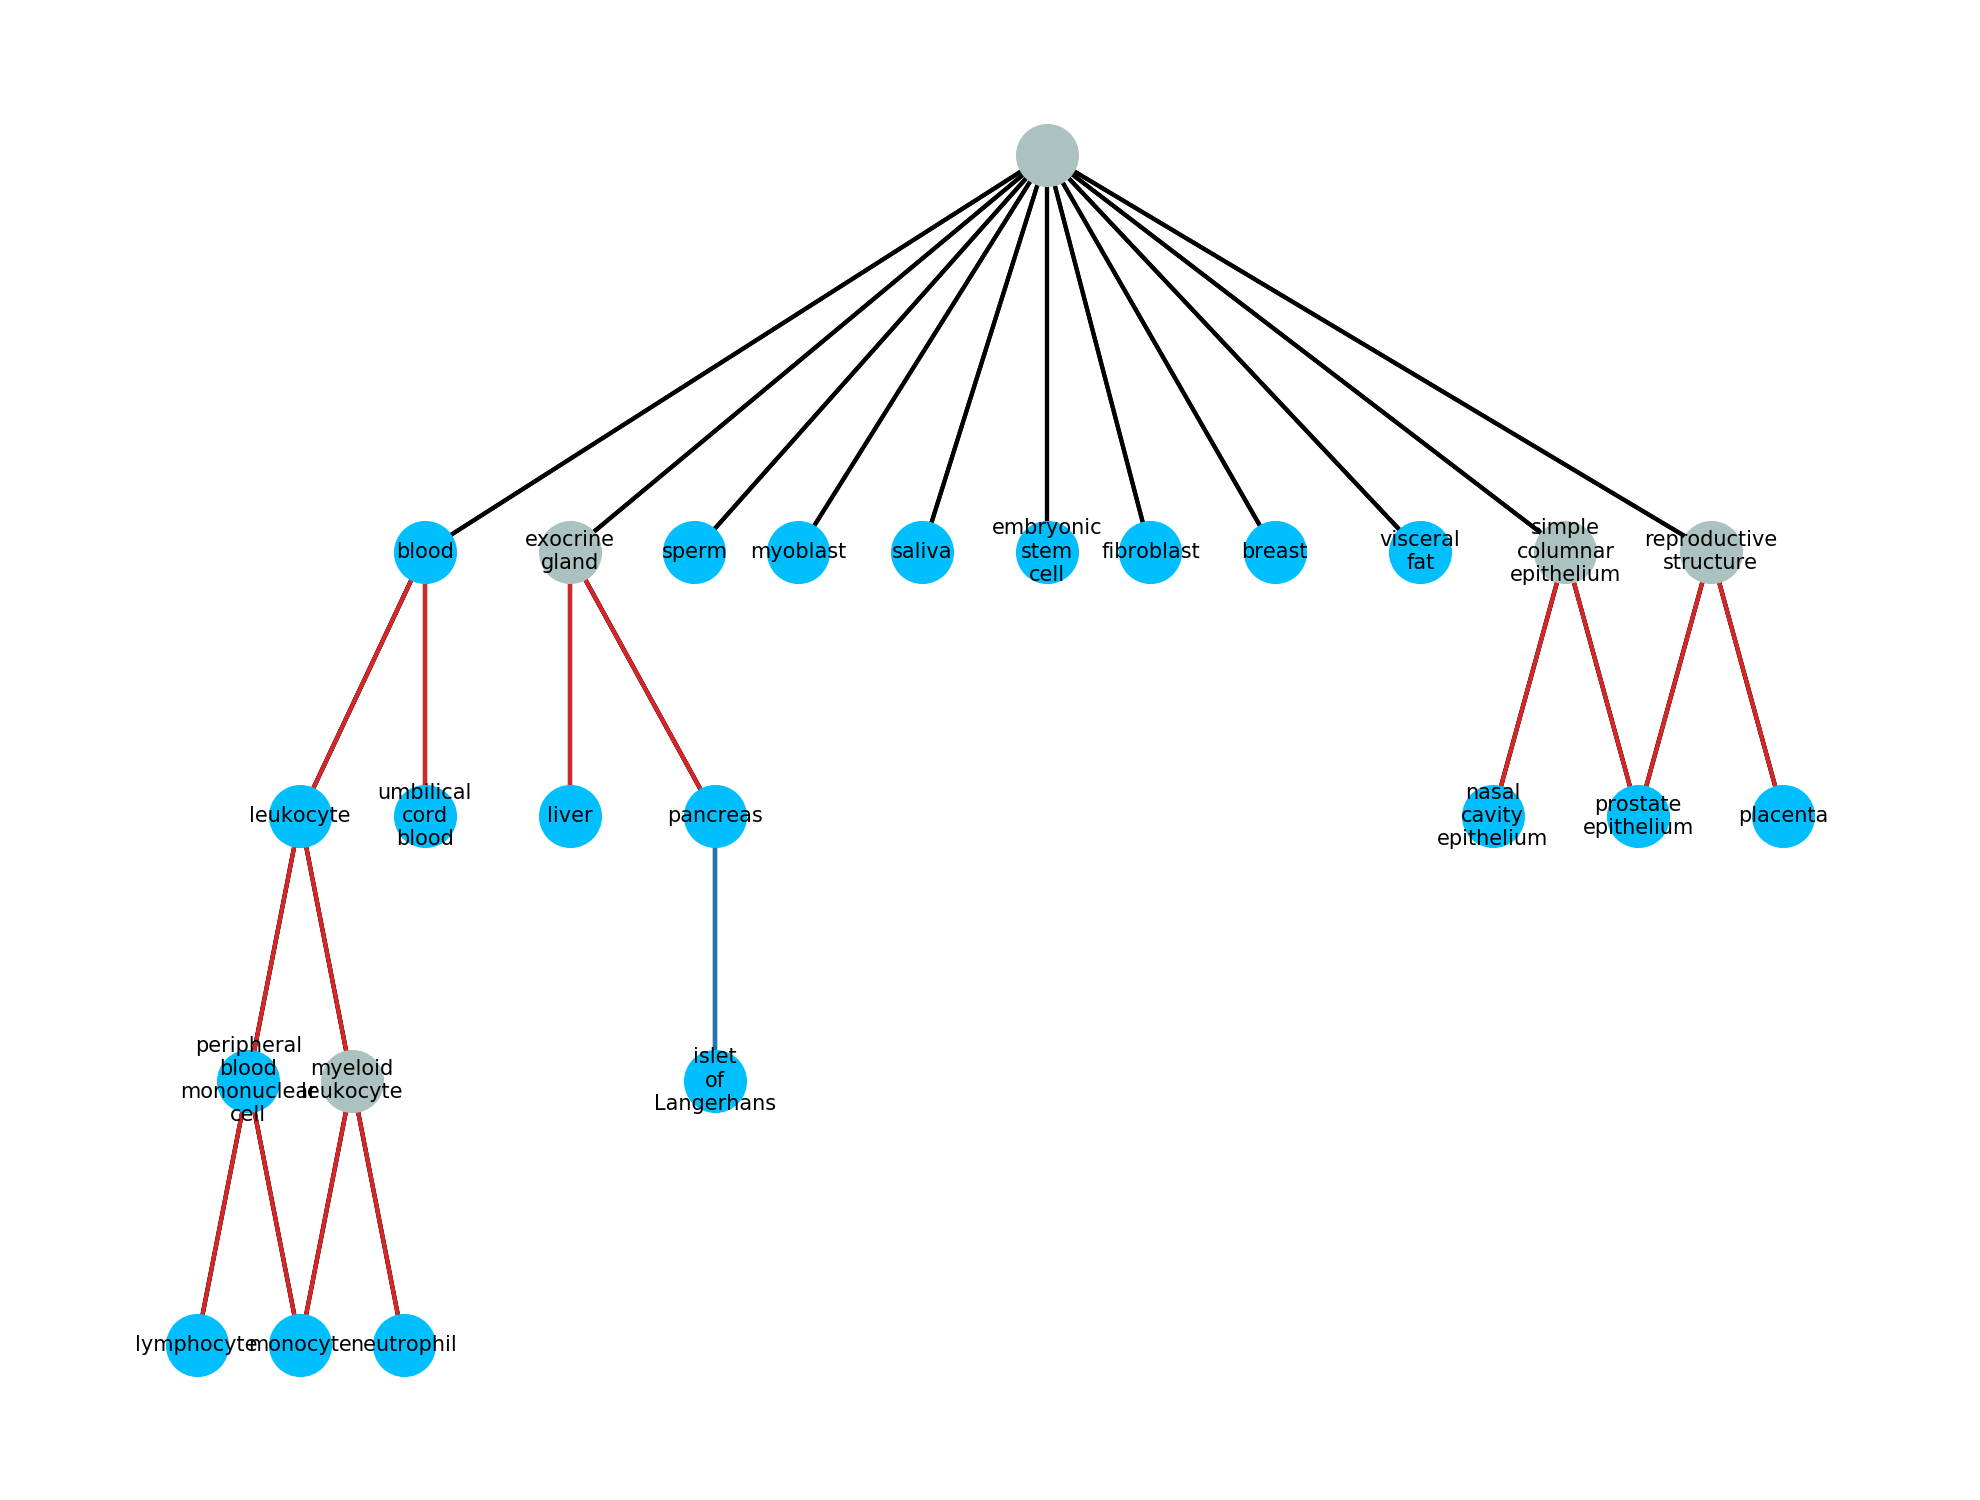

In [38]:
#display final
font_size = 5
# sample_tree = cut_tree
rooted_pos = graphviz_layout(rooted_tree, prog='dot', root='root')
for key in sample_pos.keys():
    x,y=rooted_pos[key]
    rooted_pos[key]=(x,-y)
sample_label=dict((k, label_dict[k]) for k in list(rooted_tree.nodes()) if k in label_dict)
sample_label['root'] = ''

meta_node=[name_to_id[x] for x in tissues if name_to_id[x] in rooted_tree.nodes]
rest_node=[x for x in set(rooted_tree.nodes)-set(meta_node)]

#display final structure
plt.figure(dpi=300)
nx.draw(rooted_tree, rooted_pos, nodelist=meta_node, node_color='#00bfff', labels=sample_label, with_labels=False, arrows=False, 
            font_size=font_size, node_size=node_size) # BLUE
nx.draw(rooted_tree, rooted_pos, nodelist=rest_node, node_color='#abc2c1', labels=sample_label, with_labels=False, arrows=False, 
            font_size=font_size, node_size=node_size) # GREY
nx.draw_networkx_edges(
    rooted_tree,
    rooted_pos,
    edgelist=[e for e in rooted_tree.edges() if 'is_a' in rooted_tree.get_edge_data(e[0], e[1])],
    width=1,
    alpha=1,
    edge_color="tab:red",
arrows=False)
nx.draw_networkx_edges(
    rooted_tree,
    rooted_pos,
    edgelist=[e for e in rooted_tree.edges() if 'part_of' in rooted_tree.get_edge_data(e[0], e[1])],
    width=1,
    alpha=1,
    edge_color="tab:blue",
arrows=False)

text = nx.draw_networkx_labels(rooted_tree, rooted_pos, labels=sample_label,font_size=font_size)
for _, t in text.items():
    t.set_rotation('horizontal') 

None

In [40]:
id_to_name['root'] = 'root'
name_to_id['root'] = 'root'

In [42]:
save_dill = True
save_file = True

date = "sep2024"

sample_meta=mult_meta[mult_meta['tissue_name'].isin([id_to_name[x] for x in rooted_tree.nodes()])]
print(sample_meta.shape)

if save_dill:
    with open(f"uberon_{date}_atleast{atleast}_rooted", "wb") as dill_file:
        dill.dump([rooted_tree, rooted_pos], dill_file)
if save_file:
    with open(f"uberon_{date}_atleast{atleast}_rooted_adjlist", "wb") as file:
        nx.write_multiline_adjlist(rooted_tree, file)

(2604, 7)
